# Action Space analysis for AWS DeepRacer
This notebook has been built for the [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 
provided by  the [AWS DeepRacer Community](http://join.deepracing.io).

## Contributions
As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them
to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Requirements
Installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 

## Credits
I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io)


# Log Analysis

Let's get to it.

## Installs and setups

If you are using an AWS SageMaker Notebook or Sagemaker Studio Lab to run the log analysis, you will need to ensure you install required dependencies. To do that uncomment and run the following:

In [1]:
# Make sure you have the required pre-reqs

# import sys

# !{sys.executable} -m pip install --upgrade -r requirements.txt


## Imports

Run the imports block below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

from deepracer.tracks import TrackIO, Track
from deepracer.logs import \
    SimulationLogsIO as slio, \
    PlottingUtils as pu,\
    AnalysisUtils as au, \
    DeepRacerLog, \
    S3FileHandler

import os

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

## Login

Login to AWS. There are several ways to log in:
1. On EC2 instance or Sagemaker Notebook with correct IAM execution role assigned.
2. AWS credentials available in `.aws/` through using the `aws configure` command. (DeepRacer-for-Cloud's `dr-start-loganalysis` supports this)
3. Setting the relevant environment variables by uncommenting the below section.

In [ ]:
# os.environ["AWS_DEFAULT_REGION"] = "" #<-Add your region
# os.environ["AWS_ACCESS_KEY_ID"] = "" #<-Add your access key
# os.environ["AWS_SECRET_ACCESS_KEY"] = "" #<-Add you secret access key
# os.environ["AWS_SESSION_TOKEN"] = "" #<-Add your session key if you have one

## Load waypoints for the track you want to run analysis on

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [3]:
tu = TrackIO()

for f in tu.get_tracks():
    print(f)

2022_april_open.npy
2022_april_open_ccw.npy
2022_april_open_cw.npy
2022_april_pro.npy
2022_april_pro_ccw.npy
2022_april_pro_cw.npy
2022_august_open.npy
2022_august_open_ccw.npy
2022_august_open_cw.npy
2022_august_pro.npy
2022_august_pro_ccw.npy
2022_august_pro_cw.npy
2022_july_open.npy
2022_july_pro.npy
2022_july_pro_ccw.npy
2022_july_pro_cw.npy
2022_june_open.npy
2022_june_open_ccw.npy
2022_june_open_cw.npy
2022_june_pro.npy
2022_june_pro_ccw.npy
2022_june_pro_cw.npy
2022_march_open.npy
2022_march_open_ccw.npy
2022_march_open_cw.npy
2022_march_pro.npy
2022_march_pro_ccw.npy
2022_march_pro_cw.npy
2022_may_open.npy
2022_may_open_ccw.npy
2022_may_open_cw.npy
2022_may_pro.npy
2022_may_pro_ccw.npy
2022_may_pro_cw.npy
2022_october_open.npy
2022_october_open_ccw.npy
2022_october_open_cw.npy
2022_october_pro.npy
2022_october_pro_ccw.npy
2022_october_pro_cw.npy
2022_reinvent_champ.npy
2022_reinvent_champ_ccw.npy
2022_reinvent_champ_cw.npy
2022_september_open.npy
2022_september_open_ccw.npy
202

Take the name from results above and paste below to load the key elements of the track and view the outline of it.

Loaded 155 waypoints


<Axes: >

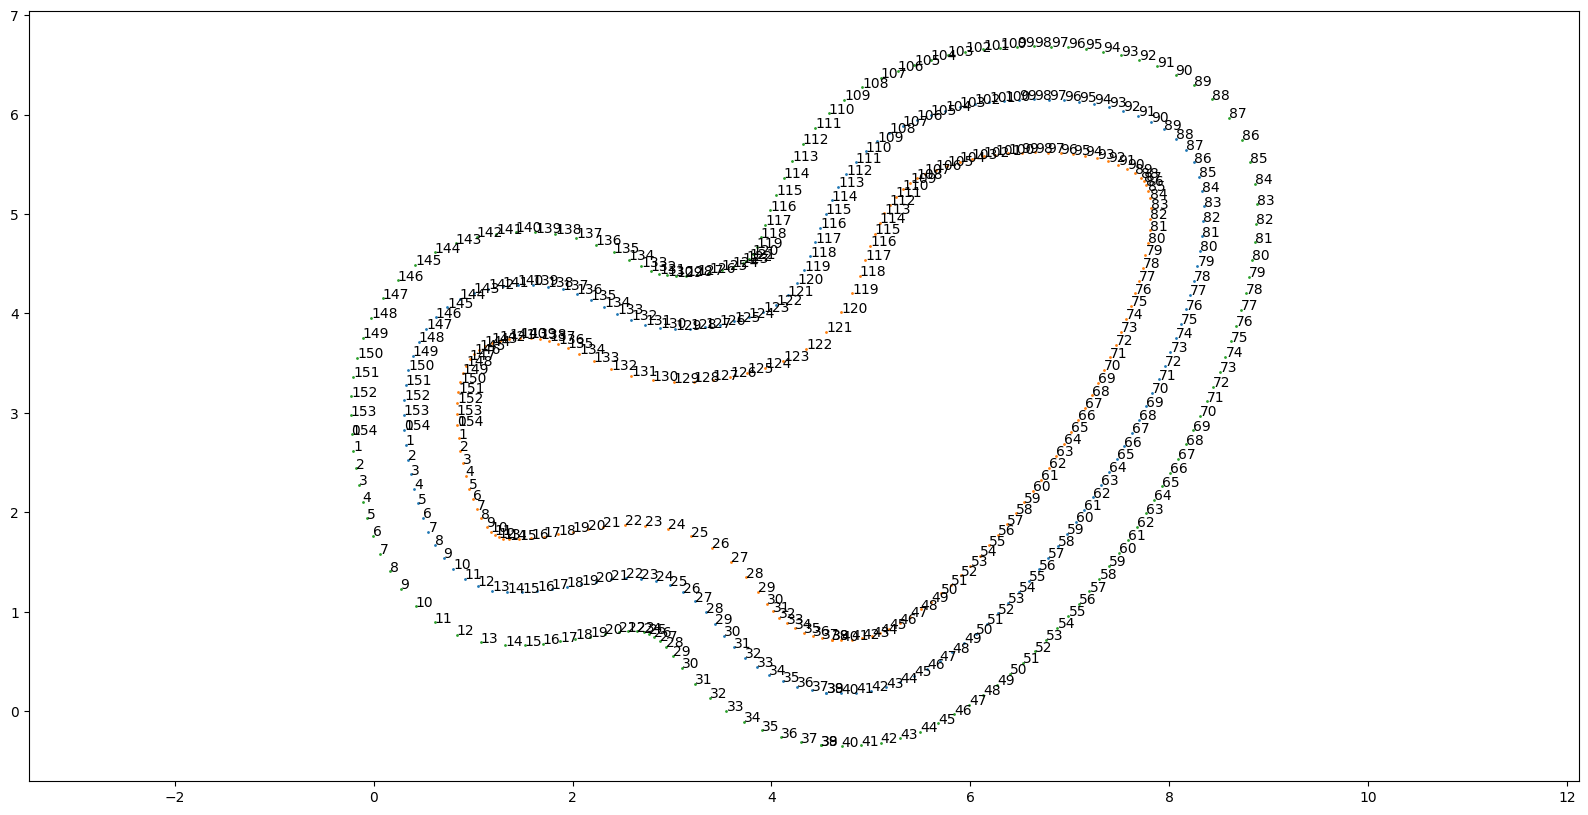

In [35]:
track: Track = tu.load_track("reInvent2019_track")
 
l_track = track.center_line
l_outer_border = track.outer_border
l_inner_border = track.inner_border

pu.plot_trackpoints(track)

## Get the logs

Depending on which way you are training your model, you will need a slightly different way to load the data. The simplest way to read in training data is using the sim-trace files directly from S3.

For other ways to read in data look at the [configuration examples](https://github.com/aws-deepracer-community/deepracer-utils/blob/master/docs/examples.md)

In [36]:
# For basic setup set prefix to exact S3 location.  For advanced setup set prefix without the hypen and number at the end e.g. for test-1, test-2 set prefix as test 
PREFIX='rl-deepracer-sagemaker'   # Name of the model, without trailing '/'
BUCKET='deepracer-thunder-compute-660ea65b-20250801-220005-99df103b'       # Bucket name is default 'bucket' when training locally
PROFILE='minio'          # The credentials profile in .aws - 'minio' for local training
S3_ENDPOINT_URL='http://minio:9000'  # Endpoint URL: None for AWS S3, 'http://minio:9000' for local training

In [37]:
fh = S3FileHandler(bucket=BUCKET, prefix=PREFIX, profile=PROFILE, s3_endpoint_url=S3_ENDPOINT_URL)
log = DeepRacerLog(filehandler=fh)
log.load_training_trace()

try:
    pprint(log.agent_and_network())
    print("-------------")
    pprint(log.hyperparameters())
    print("-------------")
    pprint(log.action_space())
except Exception:
    print("Logs not available")

df = log.dataframe()

try:
    EPISODES_PER_ITERATION=int(log.hyperparameters()['num_episodes_between_training']/(df.nunique(axis=0)['worker']))
except Exception:
    print("Multiple workers not detected, assuming 1 worker")
    EPISODES_PER_ITERATION=int(log.hyperparameters()['num_episodes_between_training'])

{'network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'sensor_list': ['FRONT_FACING_CAMERA'],
 'simapp_version': '5'}
-------------
{'batch_size': 64,
 'beta_entropy': 0.01,
 'discount_factor': 0.999,
 'e_greedy_value': 0.05,
 'epsilon_steps': 10000,
 'exploration_type': 'categorical',
 'loss_type': 'huber',
 'lr': 0.0003,
 'num_episodes_between_training': 20,
 'num_epochs': 3,
 'stack_size': 3,
 'term_cond_avg_score': 100000.0,
 'term_cond_max_episodes': 100000}
-------------
[{'speed': 1.0, 'steering_angle': 0.0},
 {'speed': 1.0, 'steering_angle': -7.5},
 {'speed': 1.0, 'steering_angle': 7.5},
 {'speed': 1.0, 'steering_angle': -15.0},
 {'speed': 1.0, 'steering_angle': 15.0},
 {'speed': 1.0, 'steering_angle': -22.5},
 {'speed': 1.0, 'steering_angle': 22.5},
 {'speed': 1.0, 'steering_angle': -30.0},
 {'speed': 1.0, 'steering_angle': 30.0},
 {'speed': 2.5, 'steering_angle': 0.0},
 {'speed': 2.5, 'steering_angle': -7.5},
 {'speed': 2.5, 'steering_angle': 7.5},
 {'speed': 2.5, 'steering_angl

## Load the trace training log

Now that the data is downloaded, we need to load it into memory. We will first read it from file and then convert to data frames in Pandas. [Pandas](https://pandas.pydata.org/) is a Python library for handling and analysing large amounts of data series. Remember this name, you may want to learn more about how to use it to get more information that you would like to get from the logs. Examples below are hardly scratching the surface.

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes into iterations. This information is valuable when later looking at graphs showing how the training progresses per iteration. You can use it to detect which iteration gave you better outcomes and, if in local training, you could move to that iteration's outcome for submissions in the AWS DeepRacer League or  for continuing the training.

The log files you have just gathered above have lines like this one:
```
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
```
* episode number
* step number
* x coordinate
* y coordinate
* yaw of the car (where the car is heading)
* decision about turning (turn value from your action space)
* decision about throttle (speed value from your action space)
* decision index (value from your action space)
* reward value
* is the car going backwards
* are all wheels on track?
* progress in the lap
* closest waypoint
* track length
* timestamp

In [38]:
# Uncomment the line of code below to evaluate a different reward function
# nr.new_reward(df, l_center_line, 'reward.reward_sample') #, verbose=True)

new reward not found, using reward as its values
Multiple workers have been detected, reloading data with grouping by unique_episode
Grouping by 'unique_episode'
Number of episodes =  2719
Number of iterations =  135


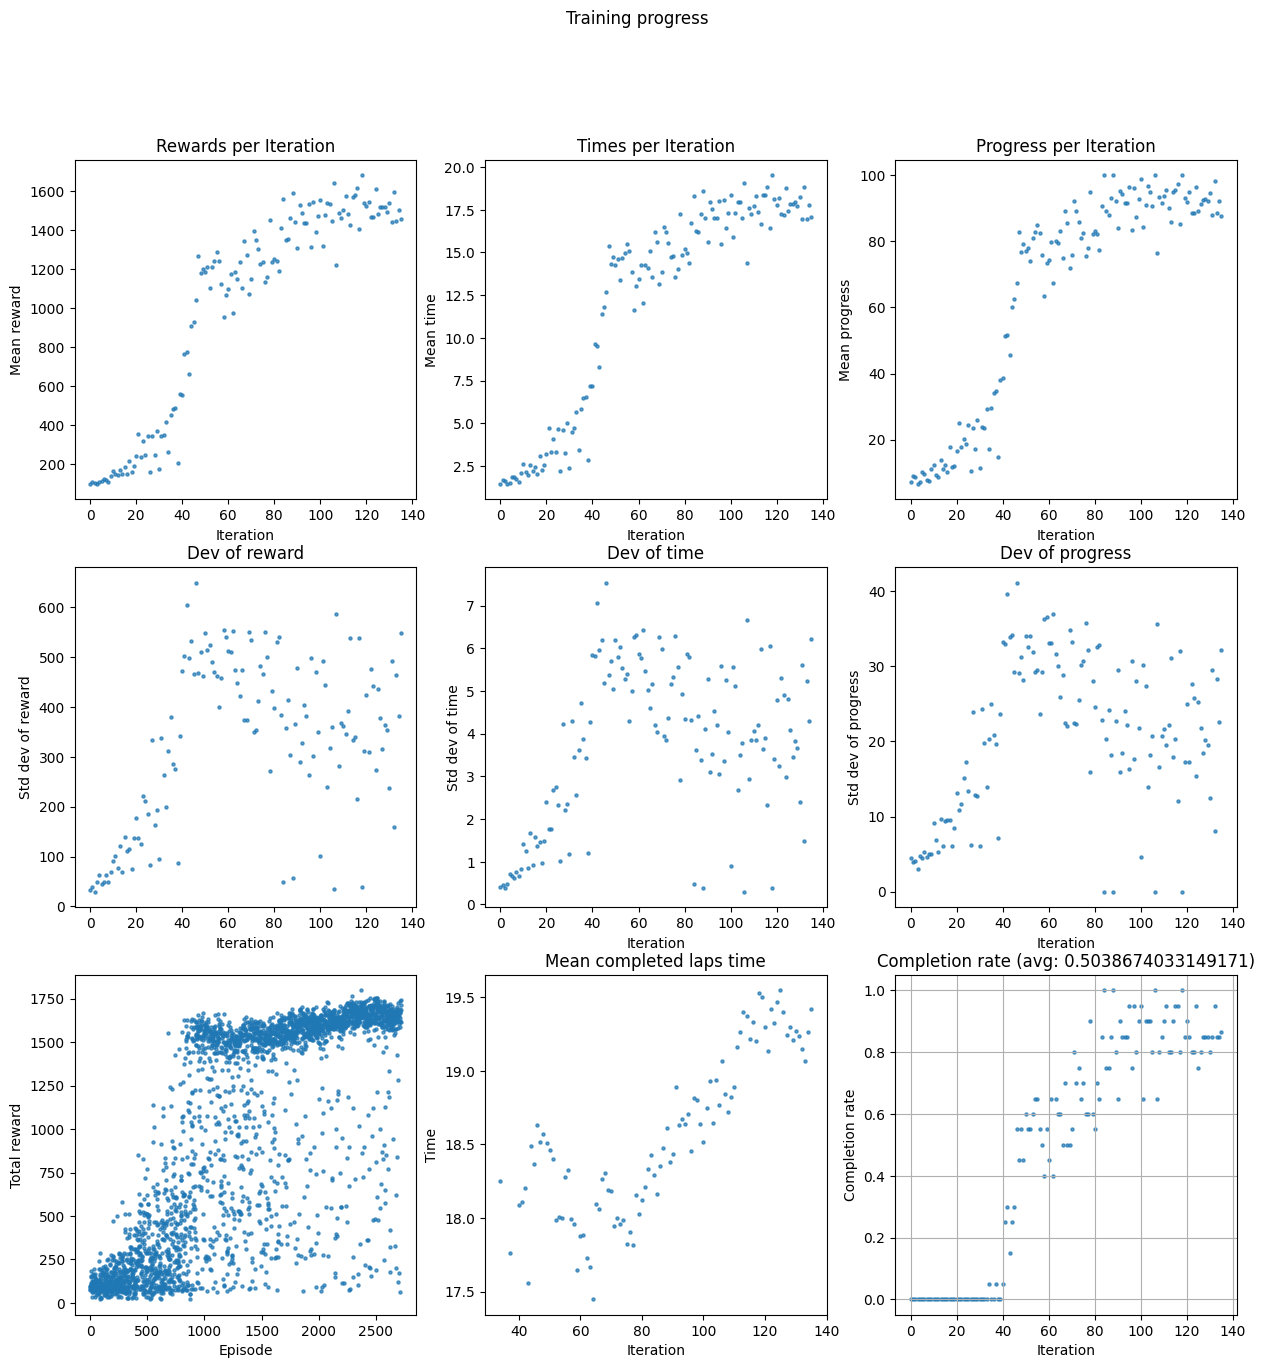

<Figure size 640x480 with 0 Axes>

In [39]:
simulation_agg = au.simulation_agg(df)
try: 
    if df.nunique(axis=0)['worker'] > 1:
        print("Multiple workers have been detected, reloading data with grouping by unique_episode")
        simulation_agg = au.simulation_agg(df, secondgroup="unique_episode")
except:
    print("Multiple workers not detected, assuming 1 worker")
au.analyze_training_progress(simulation_agg, title='Training progress')

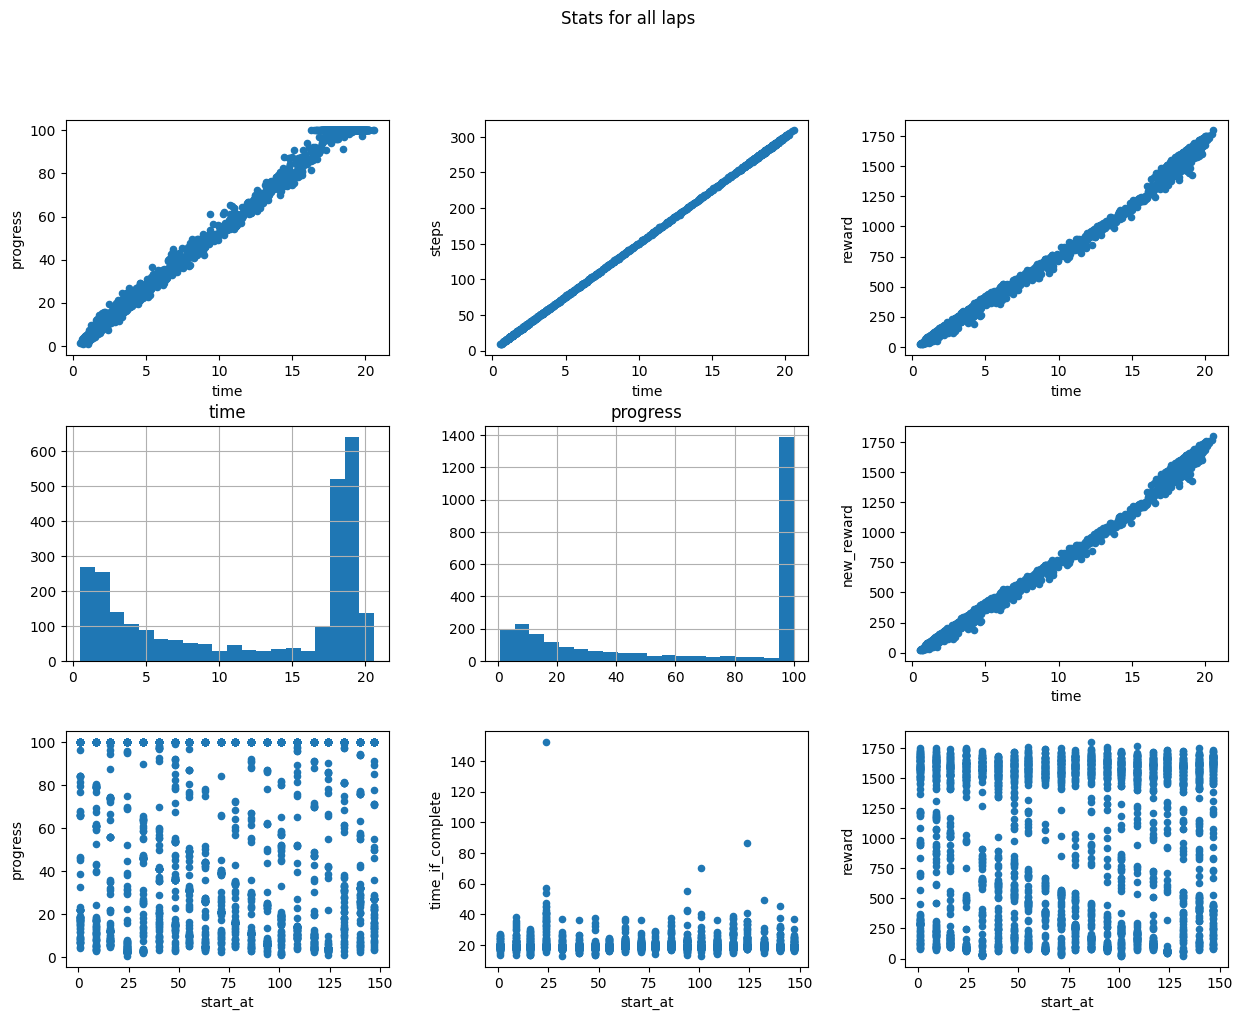

<Figure size 640x480 with 0 Axes>

In [40]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

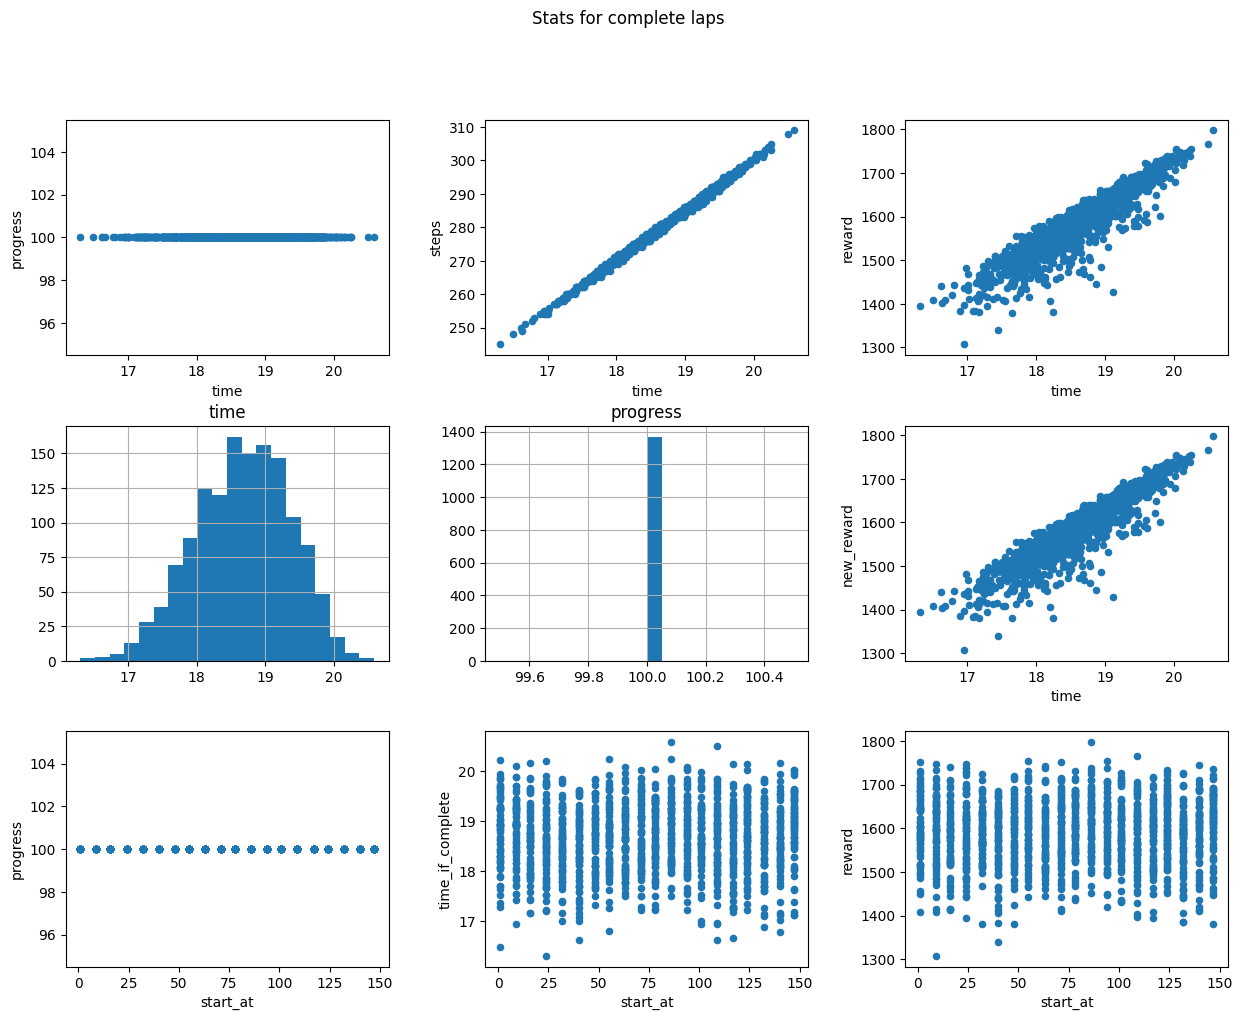

<Figure size 640x480 with 0 Axes>

In [41]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

In [42]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(5, 'reward')

iteration  unique_episode  steps  start_at  progress    time       dist  \
2366        118            2366  309.0        86     100.0  20.577  22.292990   
2294        114            2294  308.0       109     100.0  20.494  22.607129   
2507        125            2507  305.0        55     100.0  20.245  22.652215   
2452        122            2452  302.0        94     100.0  20.035  22.185494   
2509        125            2509  301.0        71     100.0  20.030  22.394462   

       new_reward     speed       reward  time_if_complete  \
2366  1797.537998  1.179612  1797.537998            20.577   
2294  1765.795332  1.243506  1765.795332            20.494   
2507  1754.510849  1.275410  1754.510849            20.245   
2452  1754.204033  1.243377  1754.204033            20.035   
2509  1751.988489  1.284053  1751.988489            20.030   

      reward_if_complete quintile  complete  
2366         1797.537998      5th         1  
2294         1765.795332      5th         1  
2507         1754.510849      5th         1  
2452         1754.204033      5th         1  
2509         1751.988489      5th         1

In [43]:
# View five most progressed episodes
simulation_agg.nlargest(5, 'progress')

iteration  unique_episode  steps  start_at  progress    time       dist  \
680         34             680  274.0        78     100.0  18.250  22.023004   
741         37             741  267.0        48     100.0  17.760  22.195198   
800         40             800  272.0         1     100.0  18.090  21.890459   
821         41             821  286.0        48     100.0  19.046  22.928336   
829         41             829  262.0        71     100.0  17.516  21.769610   

      new_reward     speed       reward  time_if_complete  reward_if_complete  \
680  1551.182210  1.503650  1551.182210            18.250         1551.182210   
741  1424.286405  1.679775  1424.286405            17.760         1424.286405   
800  1557.348672  1.512868  1557.348672            18.090         1557.348672   
821  1626.666048  1.582168  1626.666048            19.046         1626.666048   
829  1409.363111  1.509542  1409.363111            17.516         1409.363111   

    quintile  complete  
680      2nd         1  
741      2nd         1  
800      2nd         1  
821      2nd         1  
829      2nd         1

In [44]:
# View information for a couple last episodes
simulation_agg.tail()

iteration  unique_episode  steps  start_at  progress    time       dist  \
2710        135            2715  283.0       117     100.0  18.847  21.708231   
2711        135            2716  293.0       124     100.0  19.458  21.972180   
2712        135            2717  291.0       132     100.0  19.351  22.025991   
2713        135            2718  303.0       140     100.0  20.160  22.292690   
2714        135            2719  299.0       147     100.0  19.929  21.822803   

       new_reward     speed       reward  time_if_complete  \
2710  1636.395227  1.333922  1636.395227            18.847   
2711  1684.384804  1.271331  1684.384804            19.458   
2712  1617.153622  1.309278  1617.153622            19.351   
2713  1745.358524  1.212871  1745.358524            20.160   
2714  1716.445952  1.165552  1716.445952            19.929   

      reward_if_complete quintile  complete  
2710         1636.395227      5th         1  
2711         1684.384804      5th         1  
2712         1617.153622      5th         1  
2713         1745.358524      5th         1  
2714         1716.445952      5th         1

In [45]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)

# View all steps data for episode 10
df[df['episode']==320]

episode  steps         x         y     heading  steering_angle  speed  \
132587      320    1.0  0.322458  2.691188  -84.018933            22.5    4.0   
132588      320    2.0  0.322466  2.692125  -84.052217            15.0    1.0   
132589      320    3.0  0.322568  2.689965  -84.042549           -30.0    1.0   
132590      320    4.0  0.317968  2.674320  -85.447488             0.0    4.0   
132591      320    5.0  0.307372  2.653631  -88.442023             0.0    1.0   
...         ...    ...       ...       ...         ...             ...    ...   
135870      320  182.0  6.091589  5.937166 -174.681744           -22.5    1.0   
135871      320  183.0  5.964135  5.936851 -177.244646            -7.5    2.5   
135872      320  184.0  5.827823  5.963340  175.932578            30.0    1.0   
135873      320  185.0  5.776822  5.977694  172.846081            22.5    1.0   
135874      320  186.0  5.669064  5.994882  171.828966            15.0    2.5   

        action    reward   done  ...  track_len    tstamp  episode_status  \
132587      24  0.000000  False  ...  23.118222  6709.429         prepare   
132588       4  6.030117  False  ...  23.118222  6709.505     in_progress   
132589       7  5.520389  False  ...  23.118222  6709.567     in_progress   
132590      18  6.316897  False  ...  23.118222  6709.629     in_progress   
132591       0  6.015160  False  ...  23.118222  6709.688     in_progress   
...        ...       ...    ...  ...        ...       ...             ...   
135870       5  4.525342  False  ...  23.118222  8279.554     in_progress   
135871      10  1.860898  False  ...  23.118222  8279.631     in_progress   
135872       8  3.410933  False  ...  23.118222  8279.703     in_progress   
135873       6  3.410906  False  ...  23.118222  8279.764     in_progress   
135874      13  0.001000   True  ...  23.118222  8279.805         crashed   

        pause_duration  iteration worker  unique_episode  delta_time  \
132587             0.0         64      0            1280       0.000   
132588             0.0         64      0            1280       0.076   
132589             0.0         64      0            1280       0.062   
132590             0.0         64      0            1280       0.062   
132591             0.0         64      0            1280       0.059   
...                ...        ...    ...             ...         ...   
135870             0.0         64      3            1295       0.055   
135871             0.0         64      3            1295       0.077   
135872             0.0         64      3            1295       0.072   
135873             0.0         64      3            1295       0.061   
135874             0.0         64      3            1295       0.041   

        delta_dist  new_reward  
132587    0.000000    0.000000  
132588    0.000936    6.030117  
132589    0.002162    5.520389  
132590    0.016307    6.316897  
132591    0.023245    6.015160  
...            ...         ...  
135870    0.073895    4.525342  
135871    0.127455    1.860898  
135872    0.138862    3.410933  
135873    0.052982    3.410906  
135874    0.109120    0.001000  

[822 rows x 23 columns]

# Extract Action Space List from LOG file

In [46]:
# Extract Action Space List
dgr_norm = 1 # for degrees

if df['steering_angle'].max()<2: dgr_norm = 57.6923 # for radians

class act(object):
    def __init__(self, index=None, steer=None, throttle=None, rel_thr=None, color=([0,0,0])):
        self.index = index
        self.steer = steer
        self.throttle = throttle # relative throttle, max = 1
        self.rel_thr = rel_thr
        self.color = color

maxThrottle = df.speed.max()

AS = df[df['steps'] != 0].groupby(['action'], as_index=False)[['steering_angle','speed']].median()
asl = [None] * AS.shape[0]
for i in range(0,AS.shape[0]):
    j = AS.action[i].astype(int)
    #asl[AS.action[i].astype(int)] = [AS.action[i].astype(int), round(AS.steer[i]*dgr_norm,2), round(AS.throttle[i],2)]
    asl[j] = act(j, round(AS.steering_angle[i]*dgr_norm,2), round(AS.speed[i],2))
    asl[j].rel_thr = AS.speed[i] / maxThrottle
    
    cr = 8*max(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
    cg = (0+6*(30-abs(asl[j].steer)))/255
    cb = -8*min(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
 
    asl[AS.action[i].astype(int)].color = ([cr,cg,cb])

asMaxY = maxThrottle + 1

#########################################################
# define some constants for track graphs
trkFrame = 50

trkPlotXmin = df.x.min() - trkFrame
trkPlotXmax = df.x.max() + trkFrame
trkPlotYmin = df.y.min() - trkFrame
trkPlotYmax = df.y.max() + trkFrame

trkPlotXmin = min(l_outer_border[:,0]) - trkFrame
trkPlotXmax = max(l_outer_border[:,0]) + trkFrame
trkPlotYmin = min(l_outer_border[:,1]) - trkFrame
trkPlotYmax = max(l_outer_border[:,1]) + trkFrame

trkSizeX = int(trkPlotXmax - trkPlotXmin)
trkSizeY = int(trkPlotYmax - trkPlotYmin)

trkShiftX = int(trkSizeX - trkPlotXmax)
trkShiftY = int(trkSizeY - trkPlotYmax)

#print(trkSizeX,trkSizeY,trkPlotYmin,trkPlotYmax)

##########################################################
# define some constants for Action Space graphs

asPlotXmin = round(df.steering_angle.min()*dgr_norm,2)
asPlotXmax = round(df.steering_angle.max()*dgr_norm,2)
asPlotYmin = round(df.speed.min(),2)
asPlotYmax = round(df.speed.max(),2)

#df.throttle.min()
#print(asPlotXmin,asPlotXmax,asPlotYmin,asPlotYmax)

###############################################################

print("Actions: \nindex\t\tsteering\tthrottle")
for obj in asl: 
    print( obj.index, obj.steer, obj.throttle, sep ='\t\t' ) 
    

Actions: 
index		steering	throttle
0		0.0		1.0
1		-7.5		1.0
2		7.5		1.0
3		-15.0		1.0
4		15.0		1.0
5		-22.5		1.0
6		22.5		1.0
7		-30.0		1.0
8		30.0		1.0
9		0.0		2.5
10		-7.5		2.5
11		7.5		2.5
12		-15.0		2.5
13		15.0		2.5
14		-22.5		2.5
15		22.5		2.5
16		-30.0		2.5
17		30.0		2.5
18		0.0		4.0
19		-7.5		4.0
20		7.5		4.0
21		-15.0		4.0
22		15.0		4.0
23		-22.5		4.0
24		22.5		4.0
25		-30.0		4.0
26		30.0		4.0


## Function definitions

In [47]:
## Action Index Map
def plot_index_map(actSpaceList):
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(111)
    for obj in actSpaceList:
        N=100
        ax.set_title('Action Index Map')
        ax.axis([-35, 35, 0, asMaxY])
        ax.set(xlabel='Steering', ylabel='Speed',  xlim=(35,-35))
        scatter = ax.scatter((0.0 + obj.steer), (0.0 + obj.throttle),
                     color = obj.color,
                     s=1200 * obj.rel_thr,
                     alpha=0.85)
        ax.text((0.5 - obj.steer/70), (0.0 + obj.throttle/asMaxY), 
                obj.index,verticalalignment='center',
                horizontalalignment='center',
                transform=ax.transAxes, color ="w",
                fontsize=15)
    plt.show()

### Action space histograms

# 4 in 1 Histograms
def plot_4_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histograms for all episodes:') 
    fig, axs = plt.subplots(2, 2, sharex='col',figsize=(14, 10), sharey='row',  gridspec_kw={'hspace': 0, 'wspace': 0})  
    (ax1, ax2), (ax3, ax4) = axs
    ax3.hist2d(episode_data['steering_angle']*(dgr_norm), episode_data['speed'], bins=(63, 56),range=[[-31,31],[0,asMaxY]])
    ax3.set(xlabel='Steering', ylabel='Speed',  xlim=(31,-31)) 
    ax2 = plt.subplot(222, polar=True)
    ax2.set_theta_zero_location("N")
    ax2.hist2d(episode_data['steering_angle']*(dgr_norm/57.6923), episode_data['speed'], bins=(90, 23),range=[[-1.57,1.57],[0,asMaxY]])
        # ax2.hist(episode_data['action']*dgr_norm, bins=60)
    ax1.hist(episode_data['steering_angle']*dgr_norm, bins=60)
    ax4.hist(episode_data['speed'], bins=50, orientation="horizontal")# steer - throttle - actions
    for ax in fig.get_axes():
        ax.label_outer()
        
## Big Polar 2D Histogram
def plot_polar_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histogram for all episodes:')           
    fig2 = plt.figure(1, figsize=(7, 7))    
    bx = fig2.add_subplot(111, polar=True)
    bx.set_theta_zero_location("N")
    bx.hist2d(episode_data['steering_angle']*(dgr_norm/57.6923), episode_data['speed'], bins=(90, 25),range=[[-1.57,1.57],[0,asMaxY]])
       
## Ploting steps in the episodes with red dots
def plot_episode_red(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')        
        
## Ploting steps in the episodes with dots of different colors and sizes
def plot_episode_color(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        actidx = int(action)
        action_color = asl[int(action)].color
        action_s = (asl[int(action)].throttle / maxThrottle)**2 * 50 # tune the size of the dots
        #print(action_color)
        #plt.scatter([x1, car_x2], [y1, car_y2], color=action_color, s=action_s, alpha=0.65)
        plt.scatter(x1, y1, color=action_color, s=action_s, alpha=0.75)

# Action Space Visualization

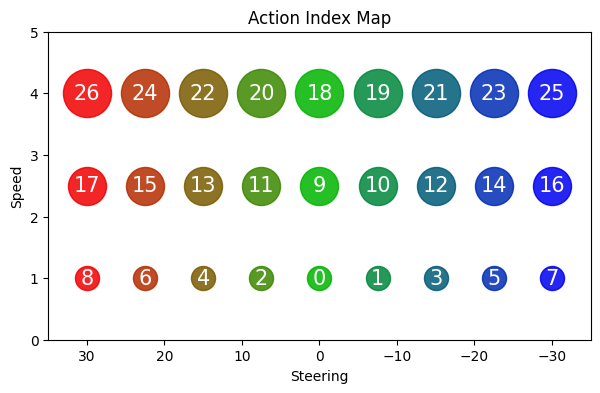

In [48]:
plot_index_map(asl)    

# Analysing data from all episodes

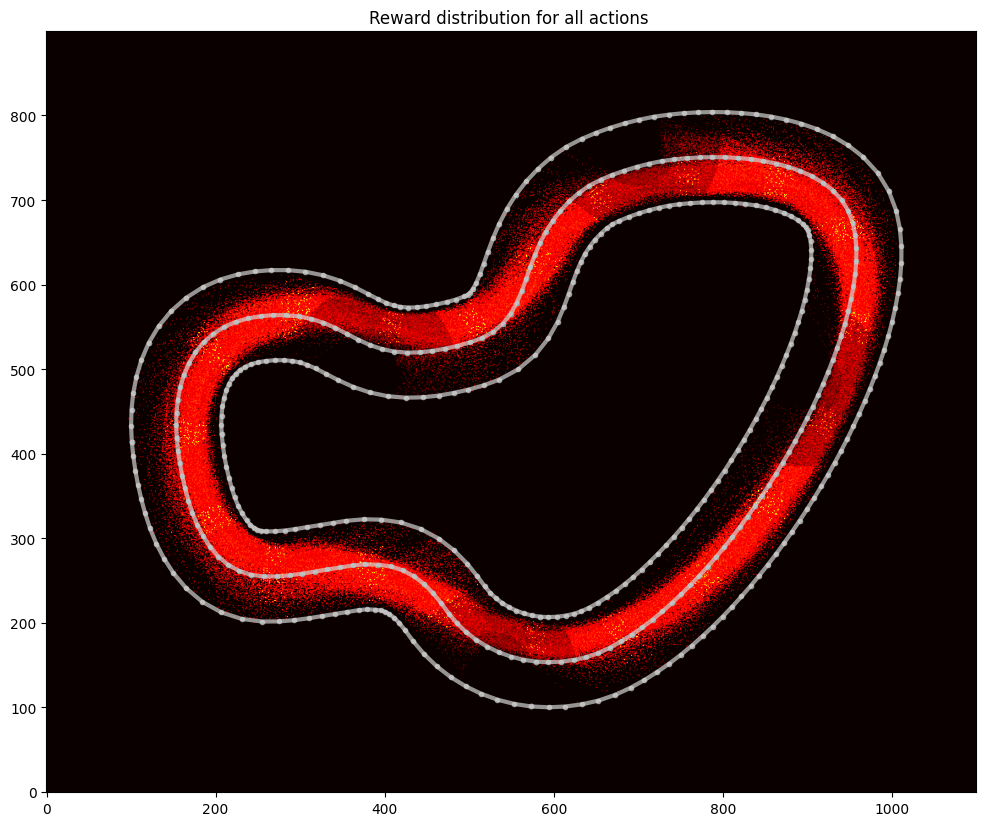

<Figure size 640x480 with 0 Axes>

In [49]:
tr_plot = pu.plot_track(df, track, value_field="reward") 

Histograms for all episodes:


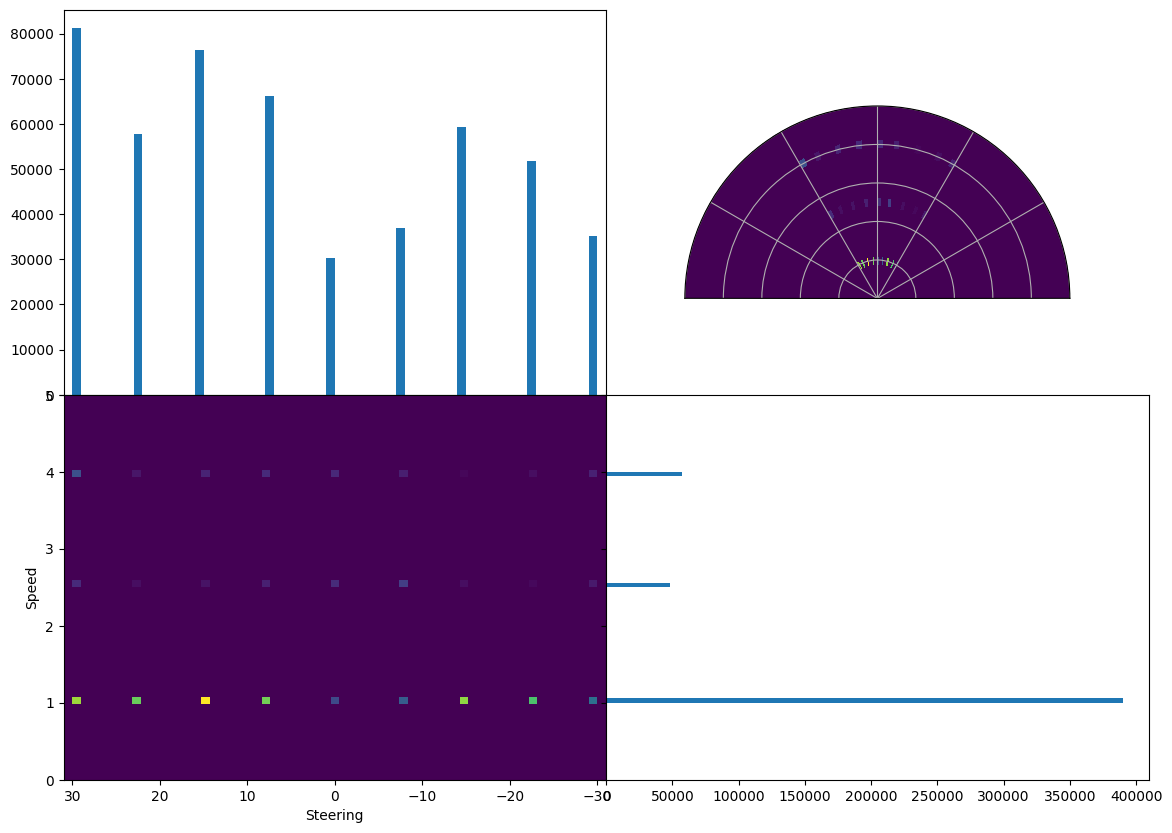

In [50]:
plot_4_hist(df)

Histogram for all episodes:


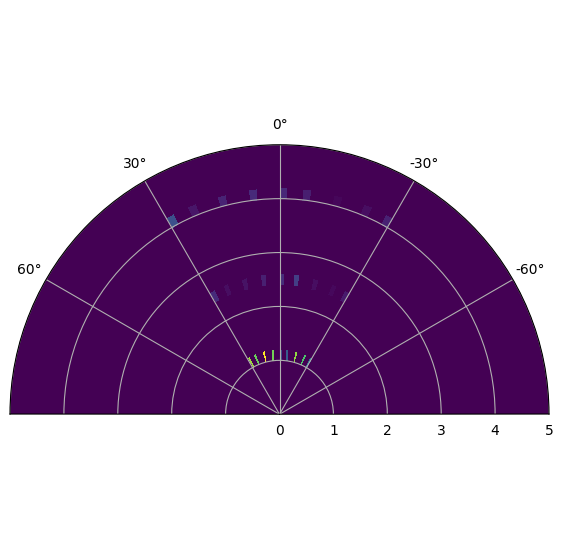

In [51]:
plot_polar_hist(df)



# Analyzing specific iteration





In [52]:
# Set iteration id
#itr = 12                      # iteration id
itr=df['iteration'].max()-10     # last iteration

Iteration: 125


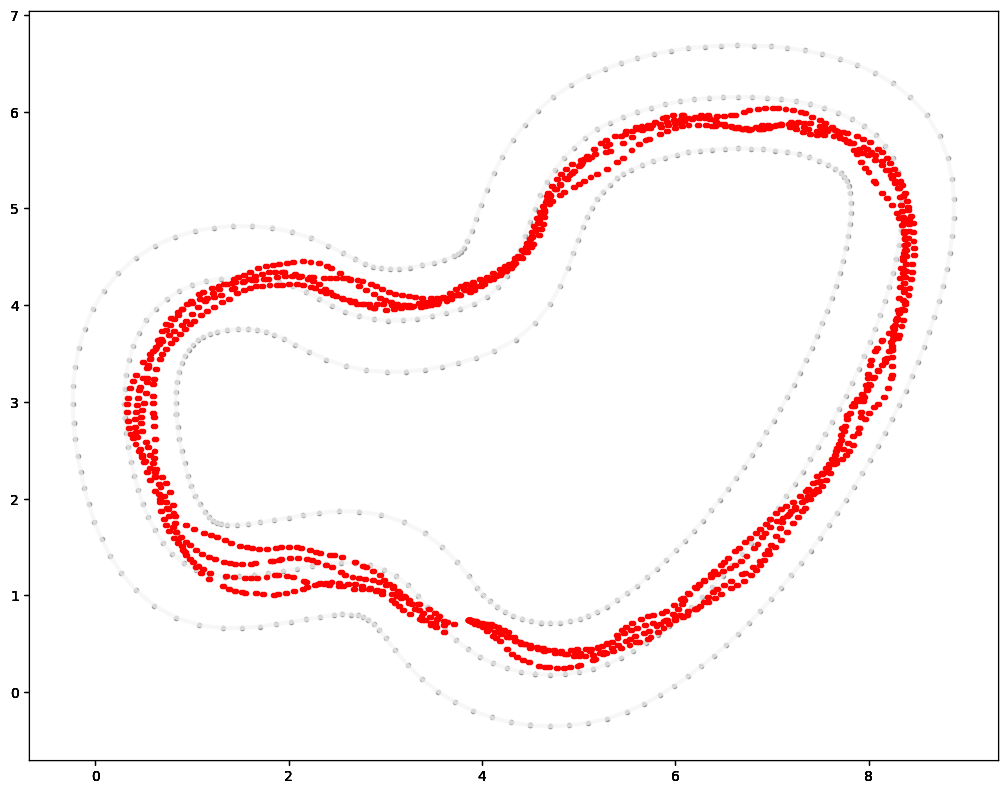

In [53]:
for i in range((itr-1)*EPISODES_PER_ITERATION, (itr)*EPISODES_PER_ITERATION):
    plot_episode_red(df,i) #,l_inner_border, l_inner_border, l_outer_border)
print('Iteration:',itr)    

Histograms for iteration: 125


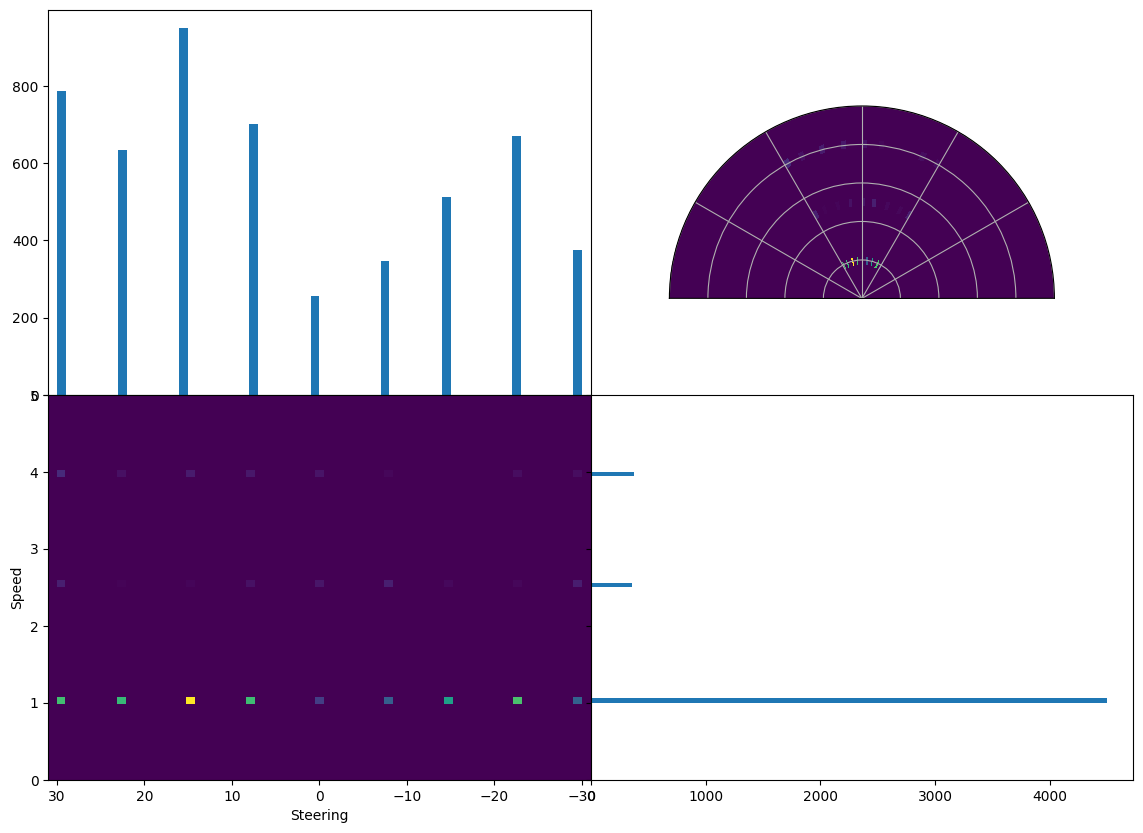

In [54]:
#plot_episode_as_hist(df, itr=25)  # specific iteration
plot_4_hist(df, itr)  # last iteration

Histograms for iteration: 125


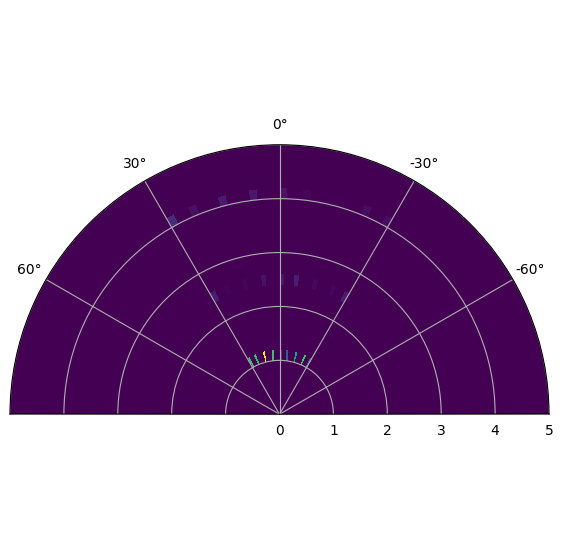

In [55]:
plot_polar_hist(df, itr)



# Analyzing specific episode



In [56]:
### choose episode id
EPZ = 210

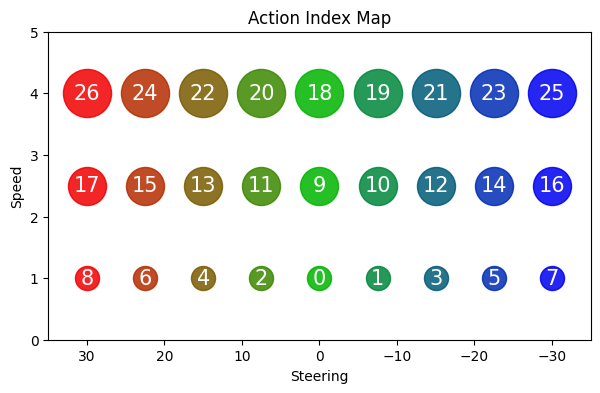

In [57]:
# Plot Index Map to understand graph
plot_index_map(asl)

Every dot is one step. Dot size is proportional to the throttle
Colors: Green = Straight, Red = Steering Left, Blue = Steering Right


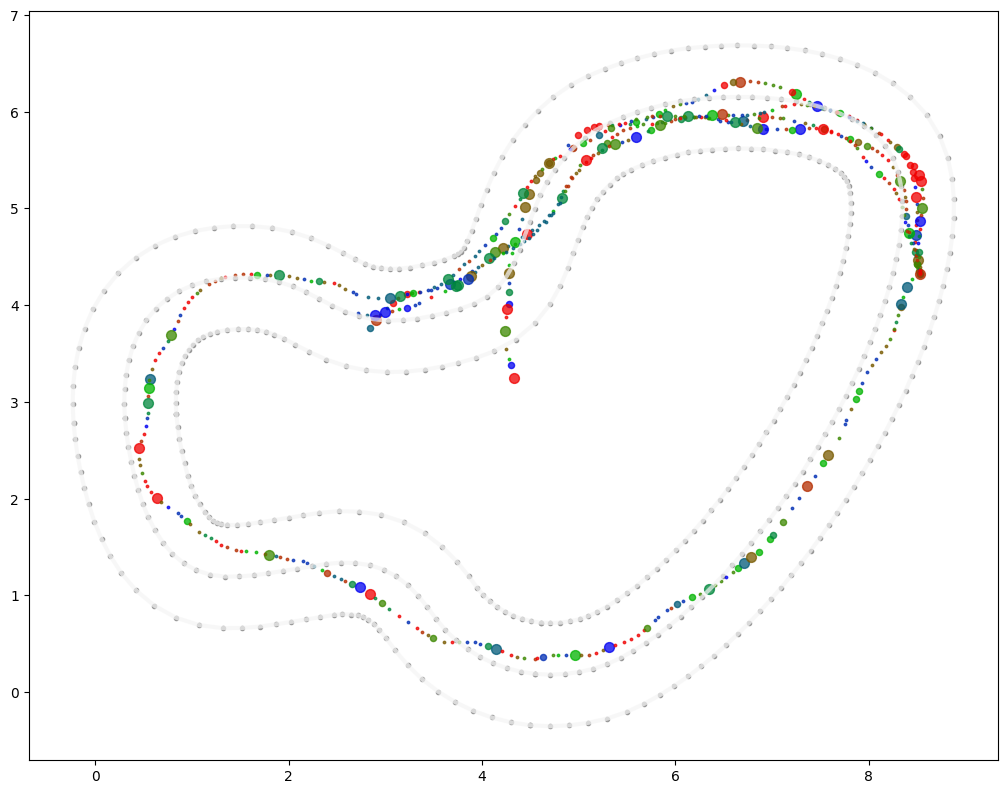

In [58]:
print("Every dot is one step. Dot size is proportional to the throttle")
print("Colors: Green = Straight, Red = Steering Left, Blue = Steering Right")
plot_episode_color(df,EPZ) #, l_inner_border, l_inner_border, l_outer_border) # arbitrary episode

Histograms for episode: 210


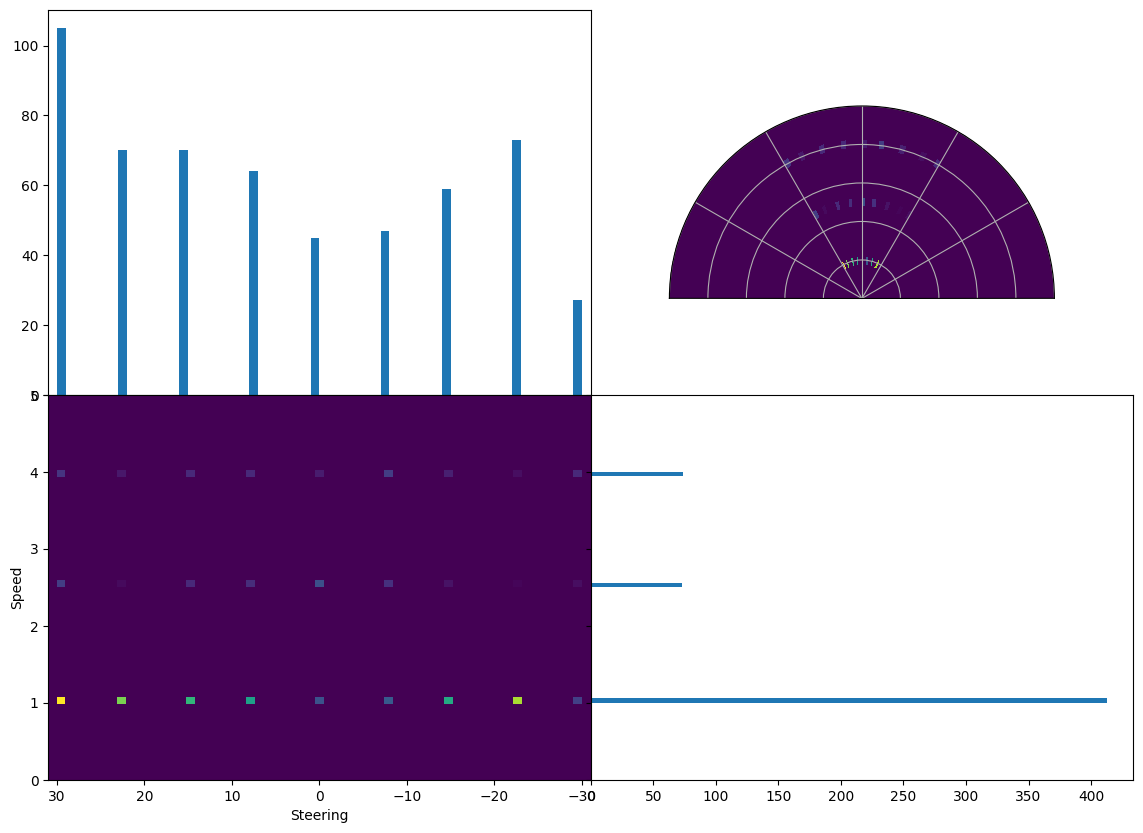

In [59]:
plot_4_hist(df, E = EPZ)

Histograms for episode: 210


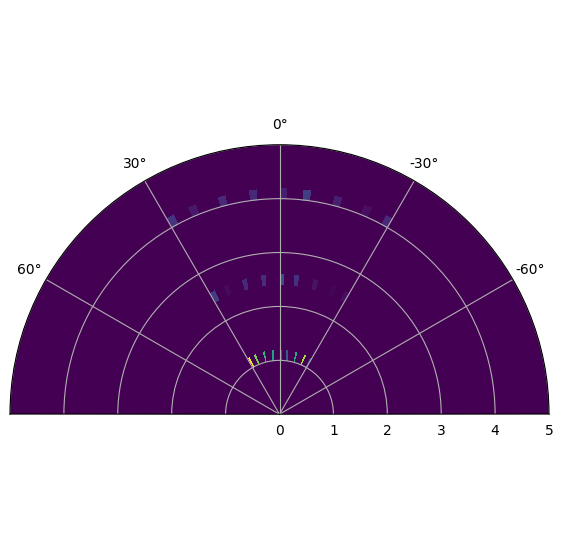

In [60]:
plot_polar_hist(df, E = EPZ)

<Axes: xlabel='closest_waypoint'>

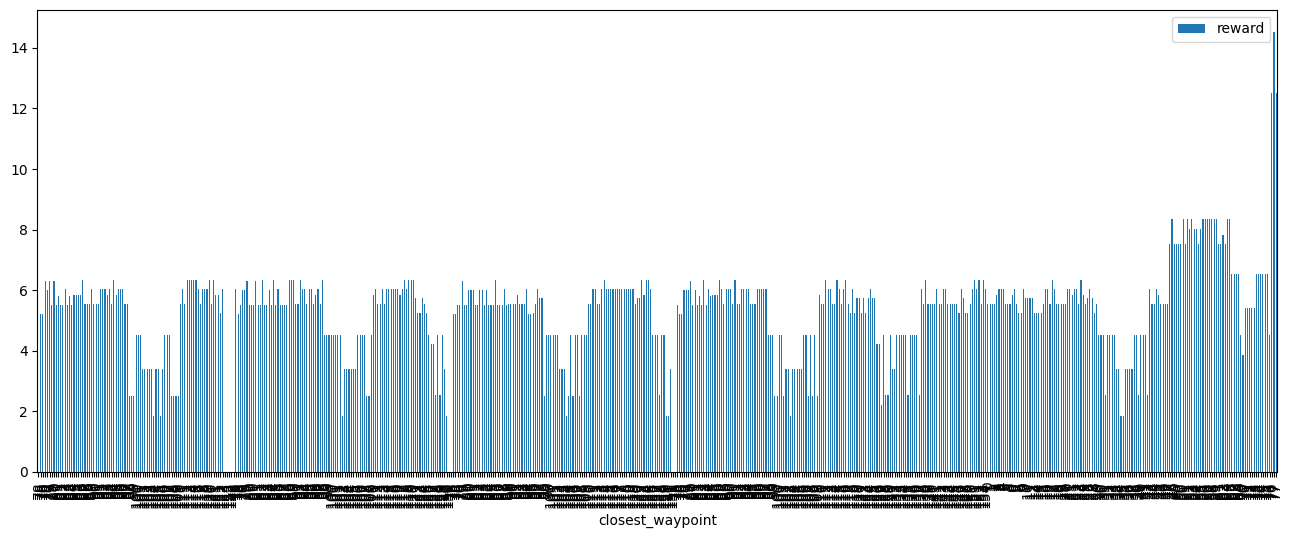

In [61]:
#This shows a histogram of actions per waypoint. Will let you spot potentially problematic places
episode = df[df['episode']==EPZ]
episode[:-1].plot.bar(x='closest_waypoint', y='reward',figsize=(16, 6))

# Analyzing Actions
## You can analyze all actions or only set of actions with indexes defined in setActions



 Heatmap for action with index 0: steering: 0.0, throttle: 1.0


<Figure size 640x480 with 0 Axes>

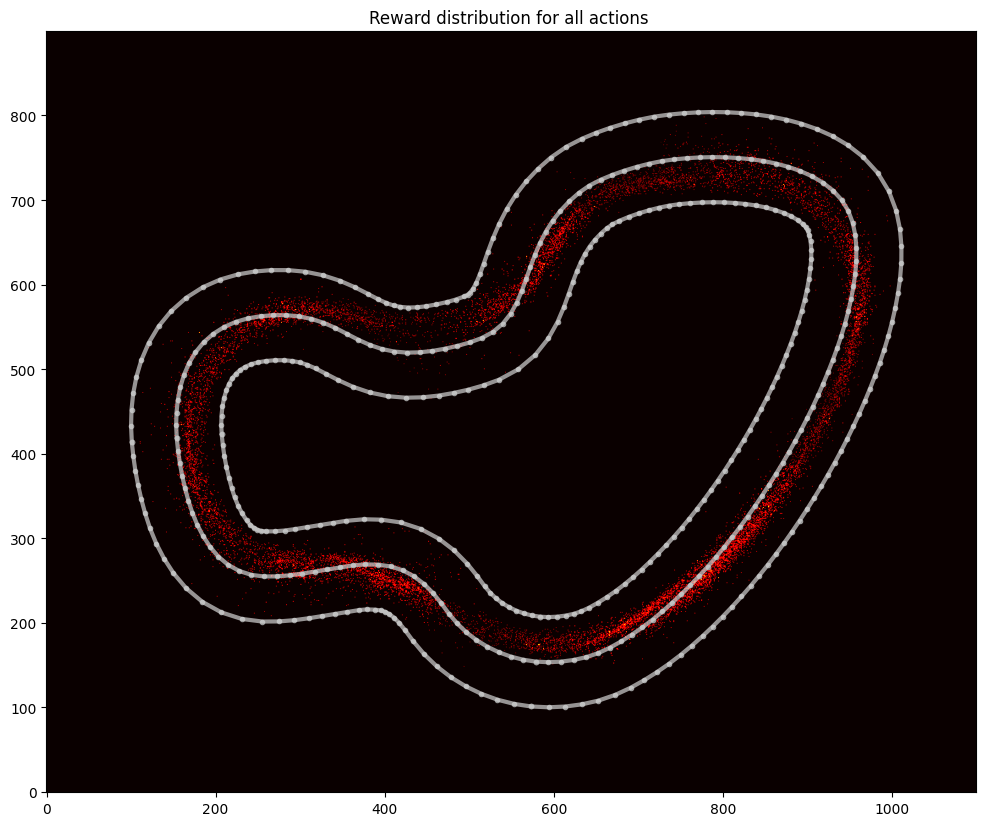

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 1: steering: -7.5, throttle: 1.0


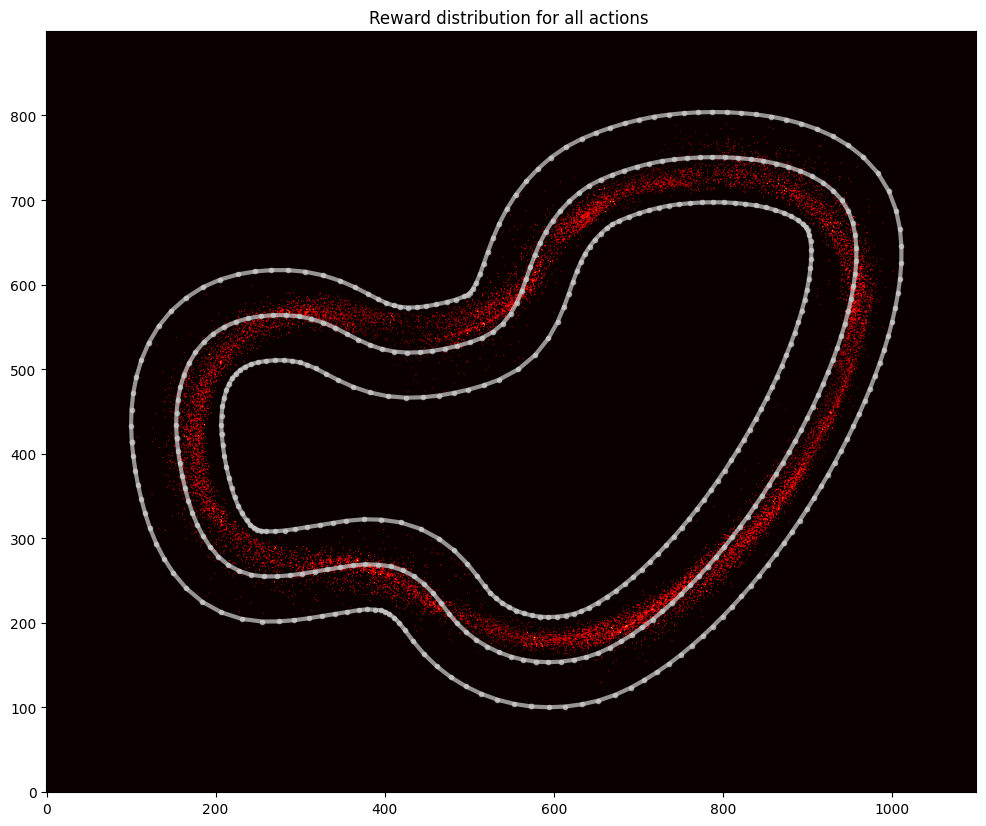

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 2: steering: 7.5, throttle: 1.0


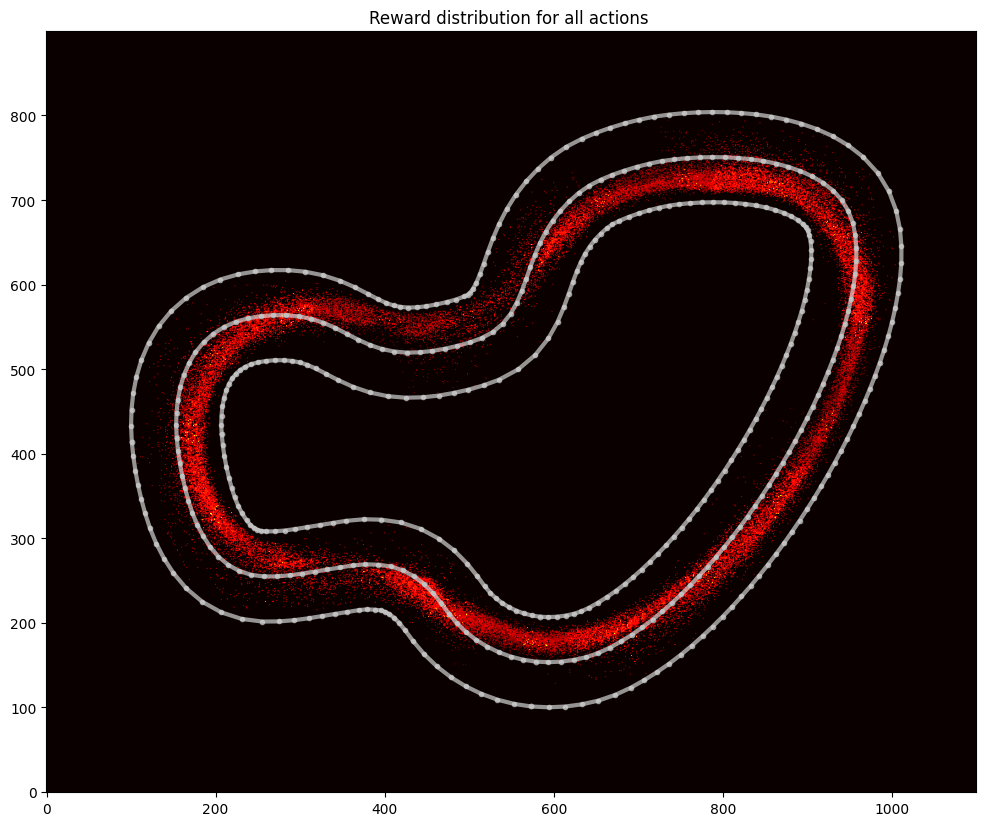

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 3: steering: -15.0, throttle: 1.0


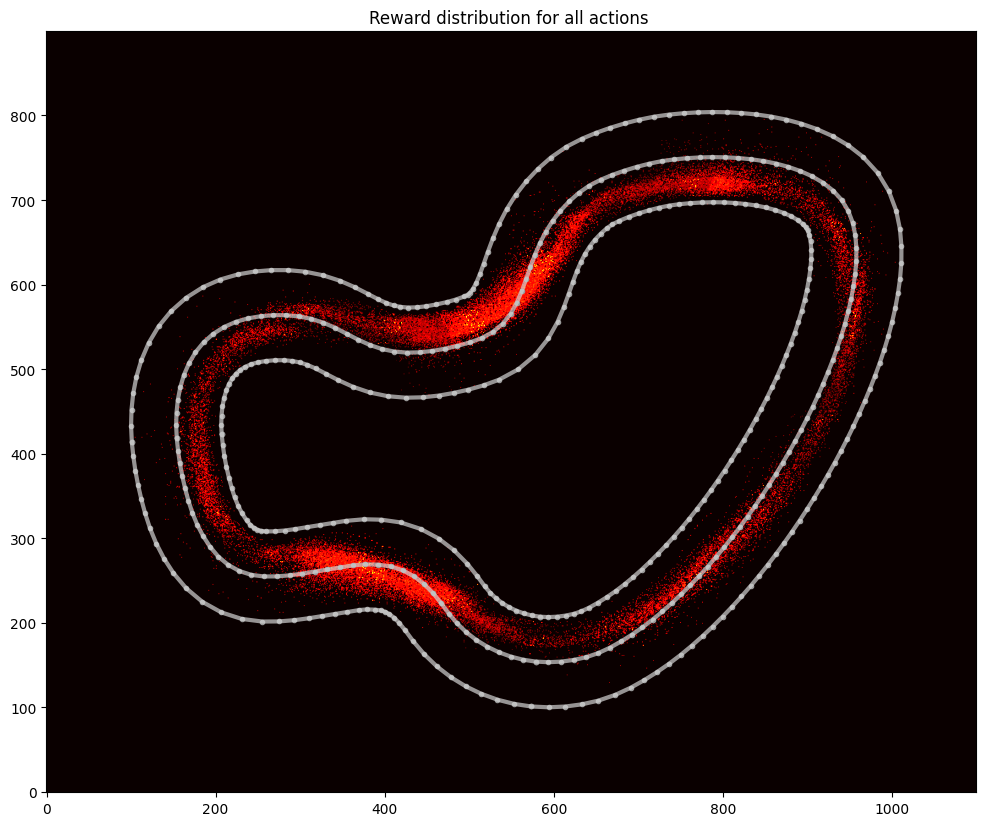

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 4: steering: 15.0, throttle: 1.0


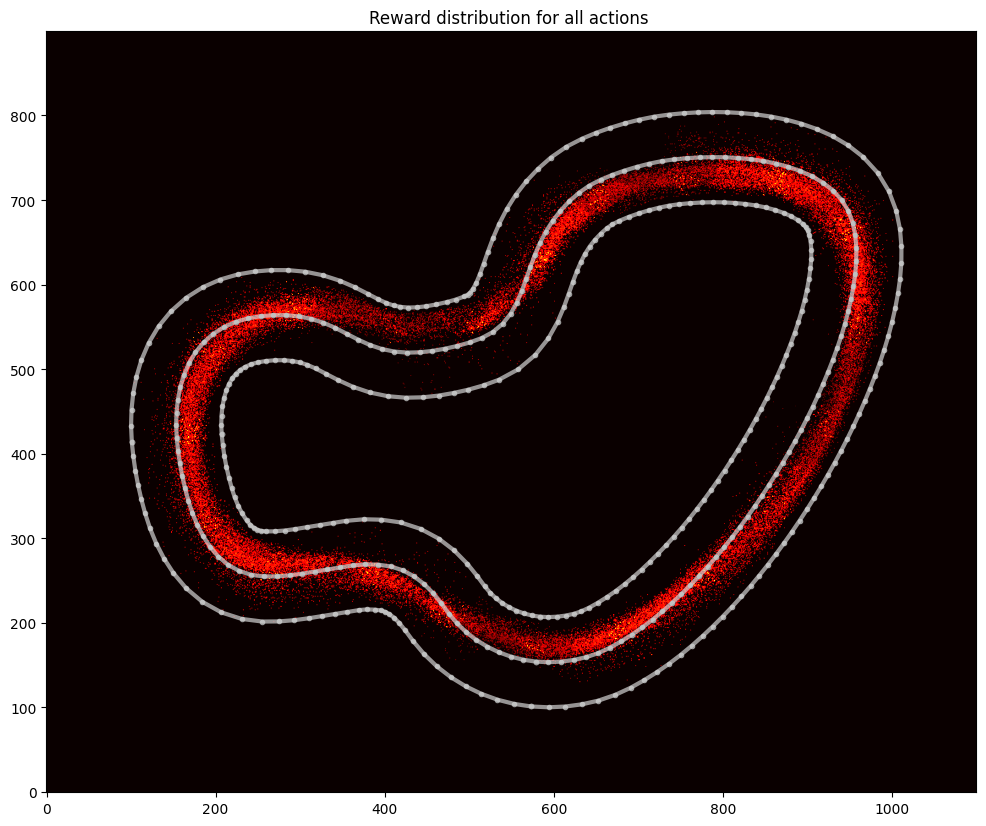

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 5: steering: -22.5, throttle: 1.0


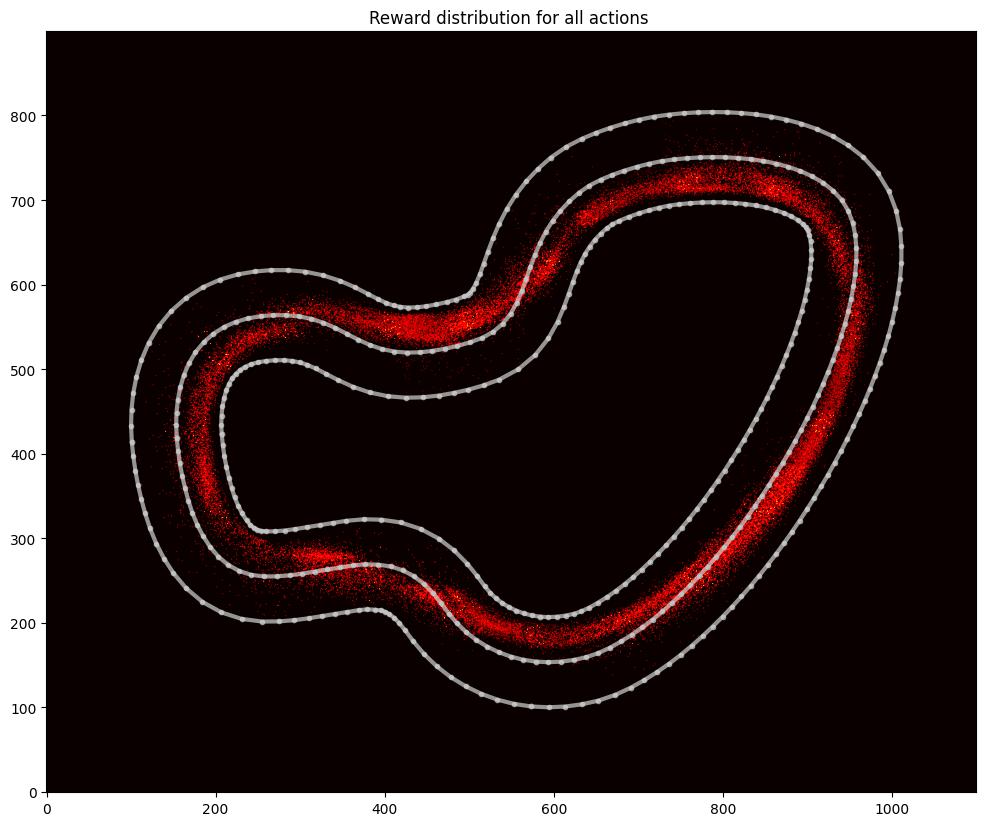

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 6: steering: 22.5, throttle: 1.0


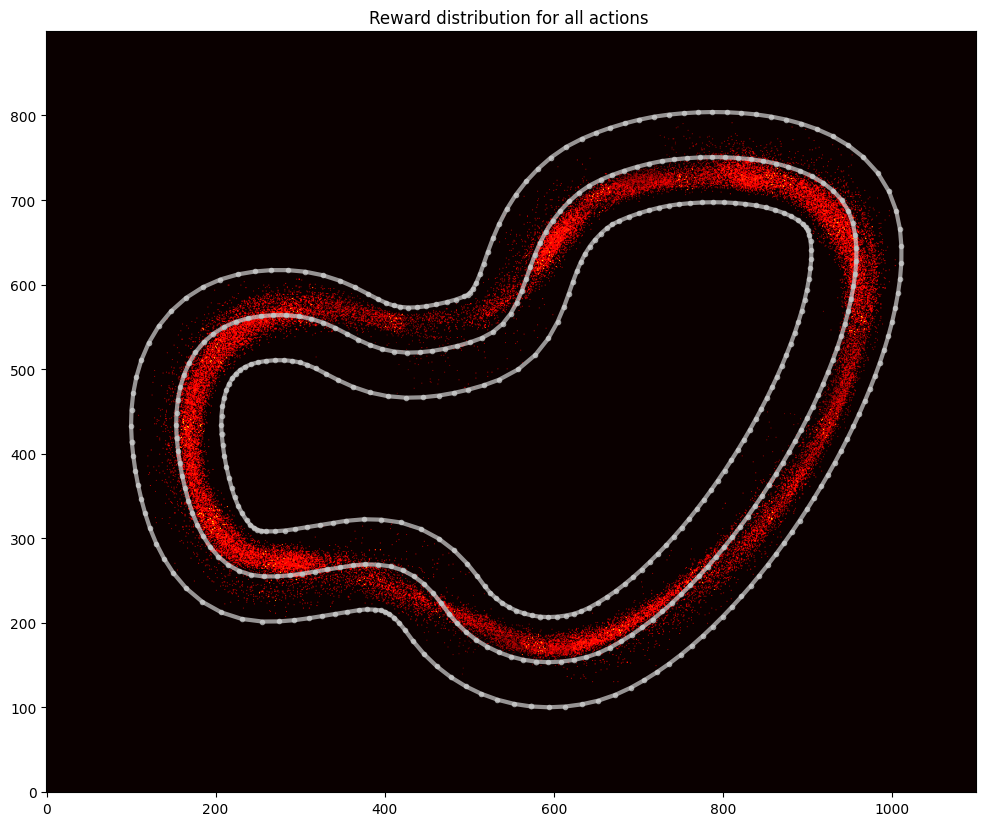

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 7: steering: -30.0, throttle: 1.0


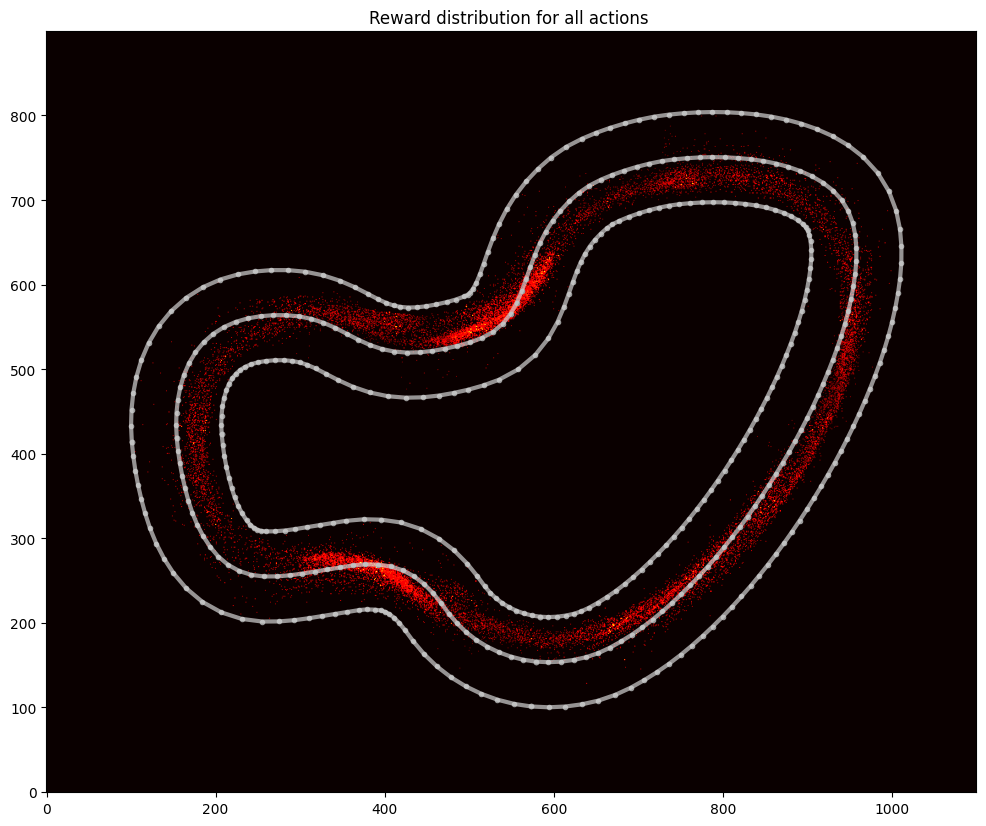

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 8: steering: 30.0, throttle: 1.0


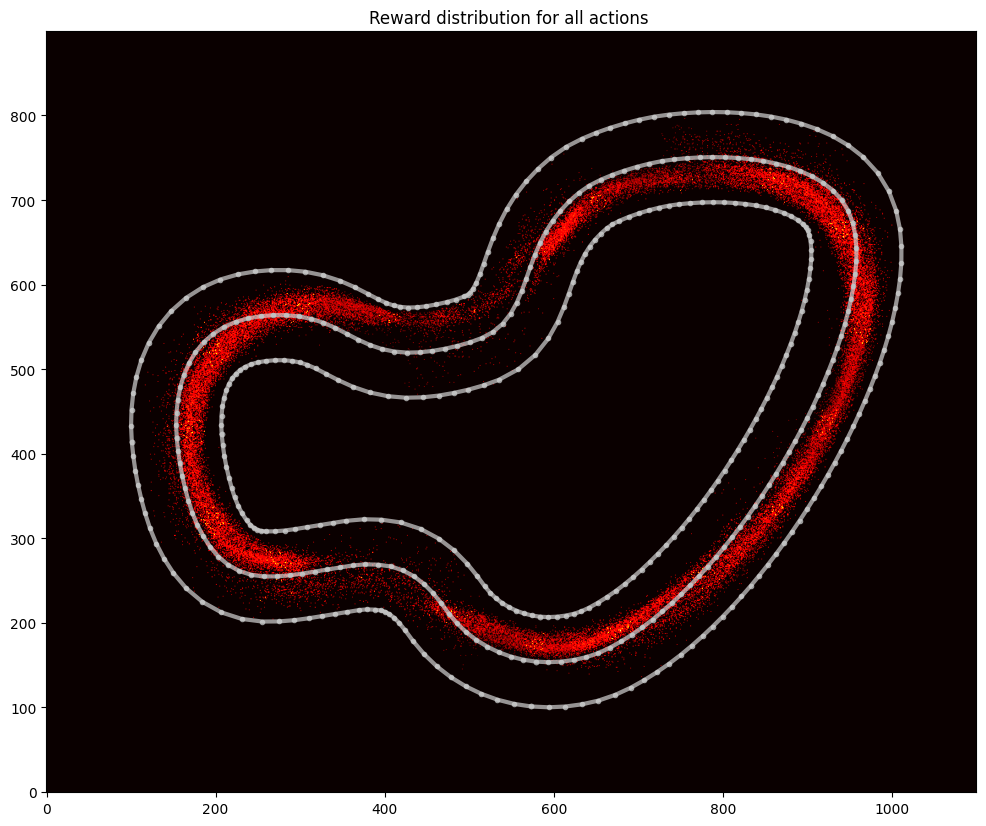

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 9: steering: 0.0, throttle: 2.5


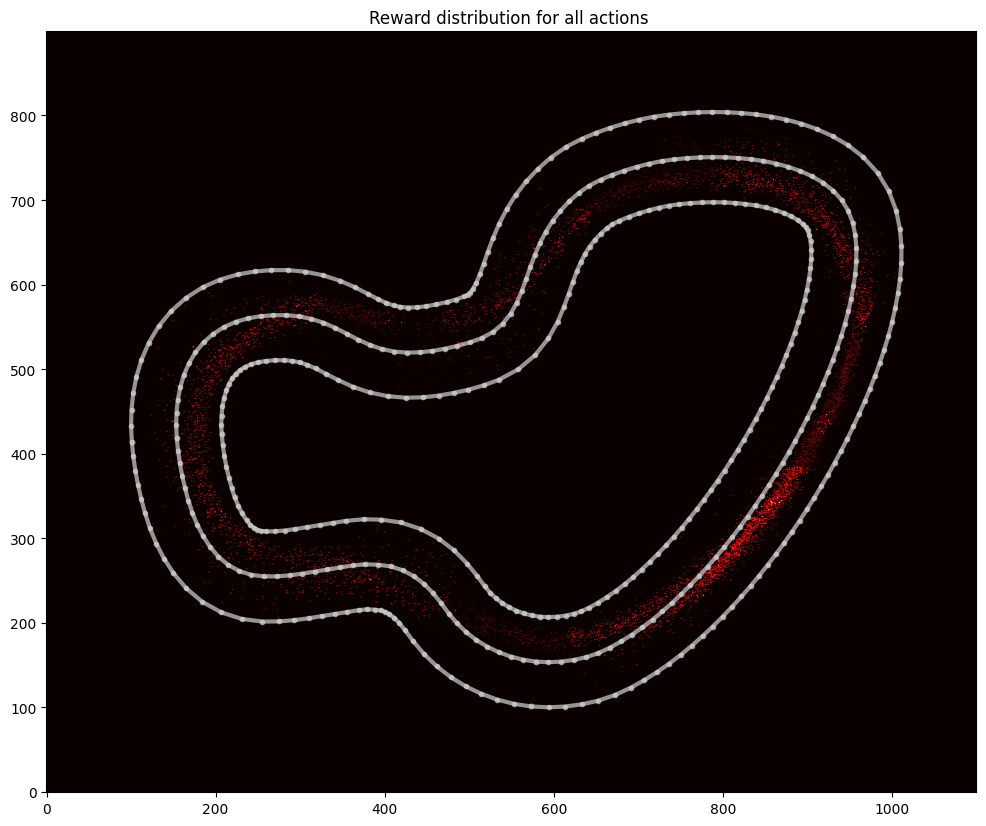

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 10: steering: -7.5, throttle: 2.5


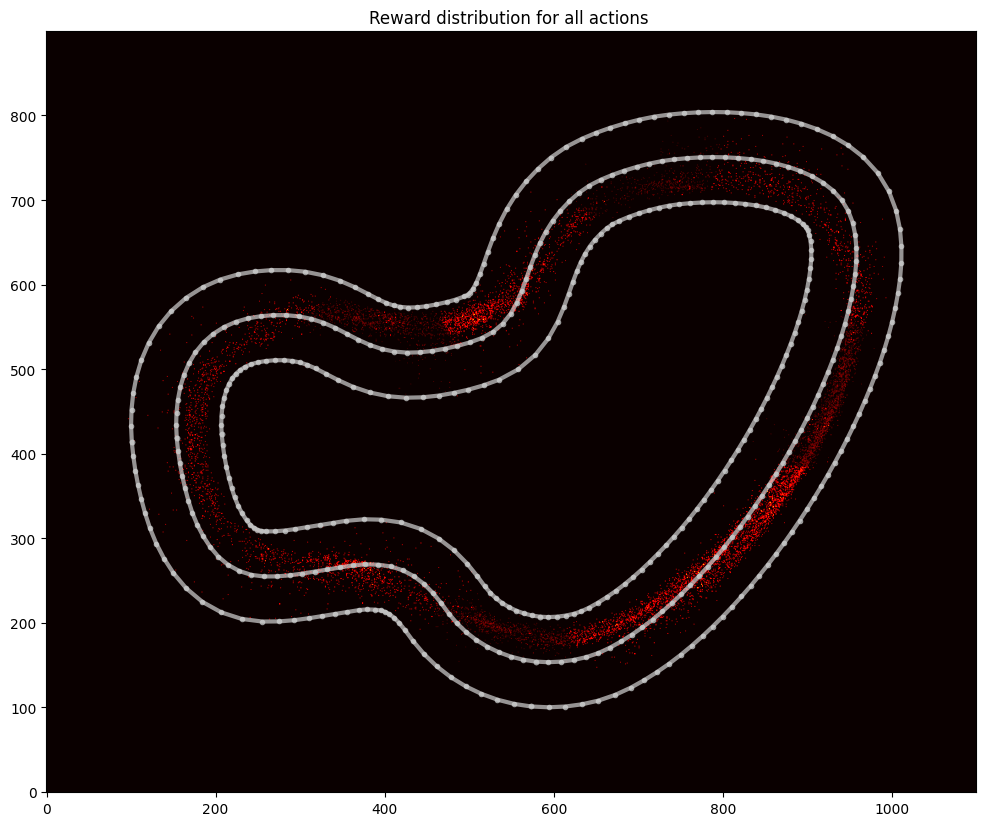

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 11: steering: 7.5, throttle: 2.5


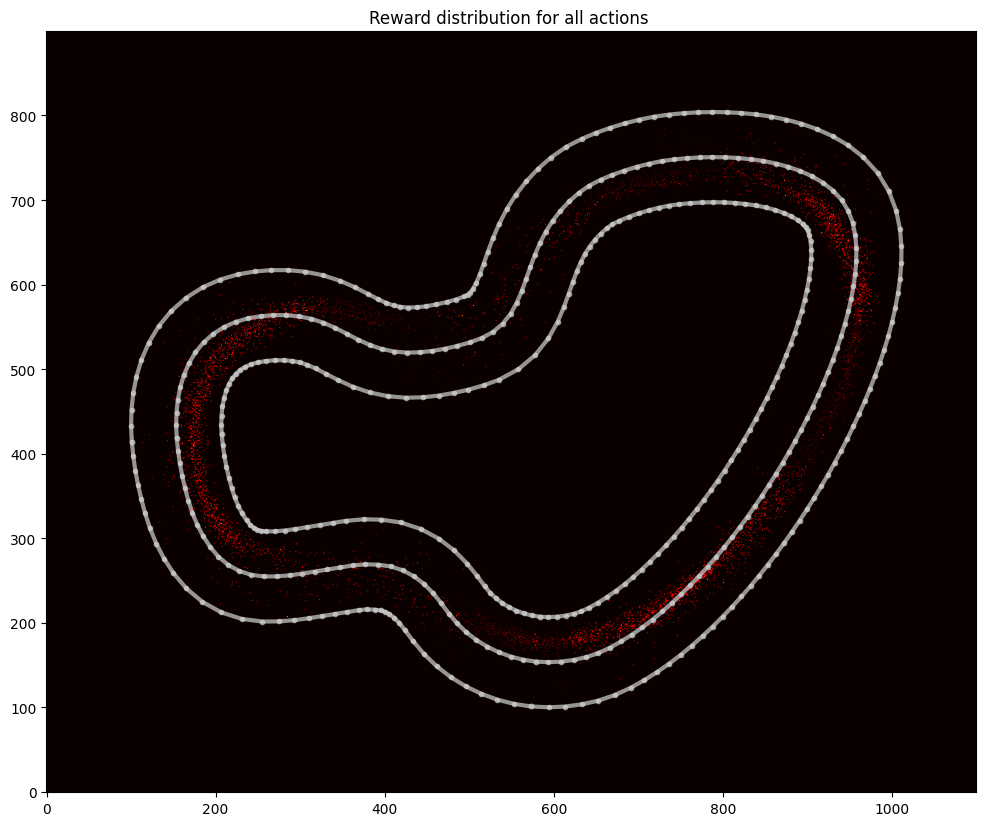

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 12: steering: -15.0, throttle: 2.5


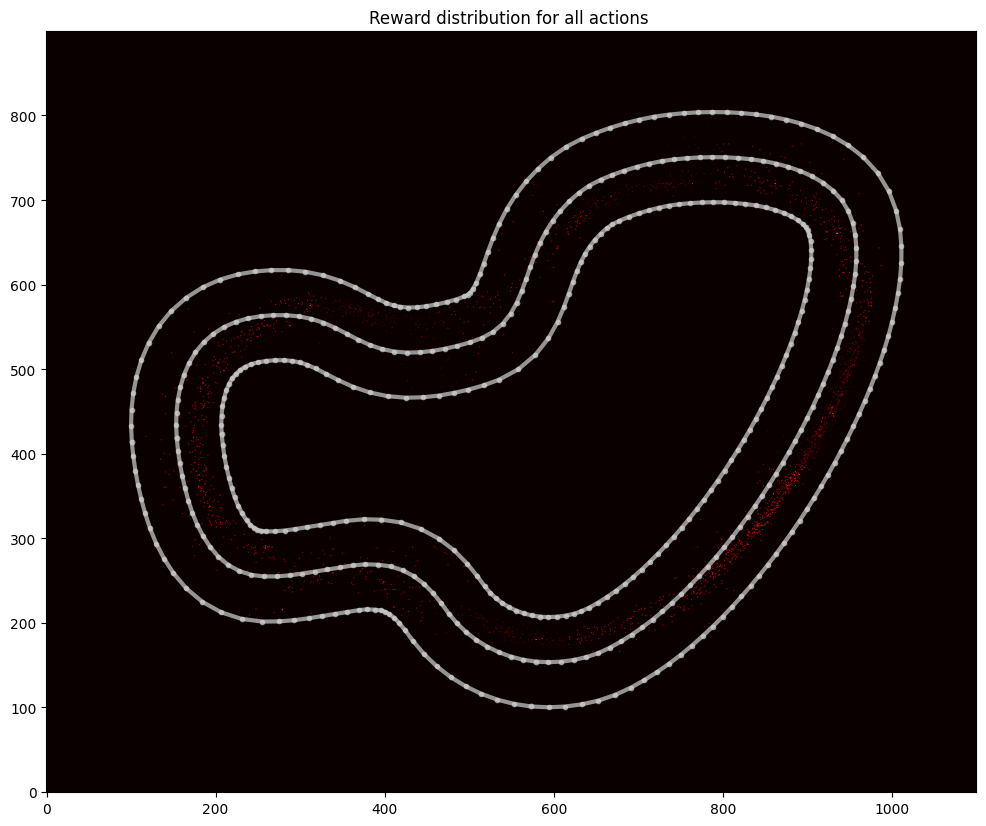

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 13: steering: 15.0, throttle: 2.5


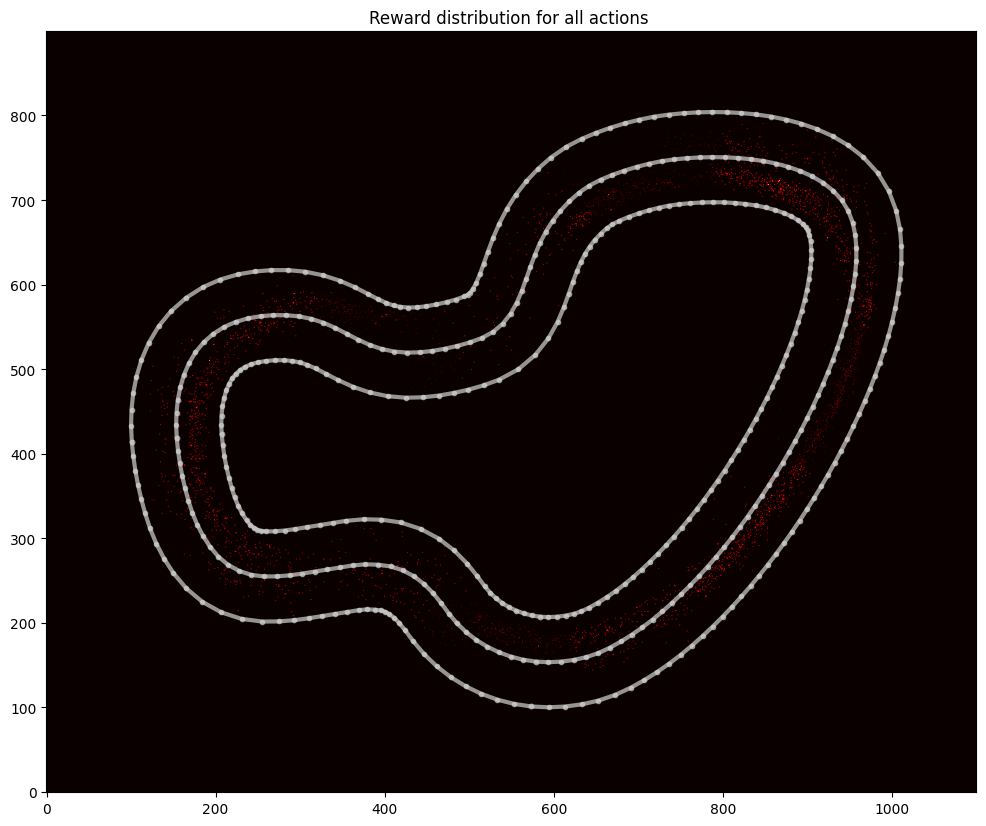

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 14: steering: -22.5, throttle: 2.5


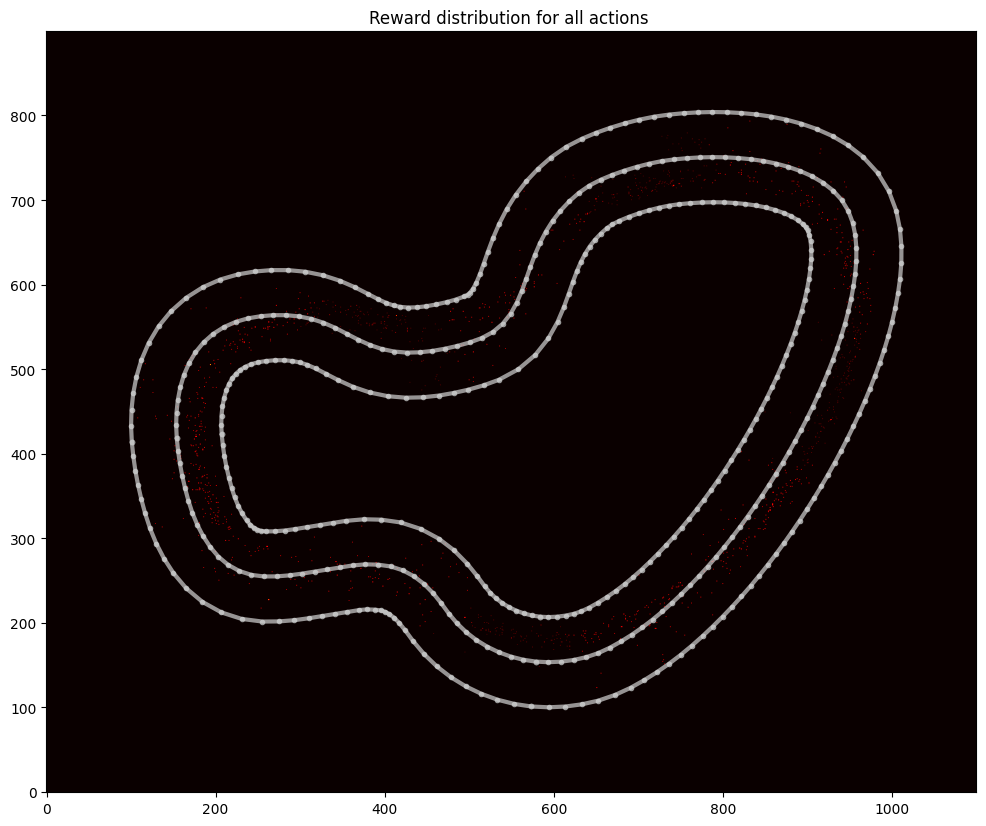

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 15: steering: 22.5, throttle: 2.5


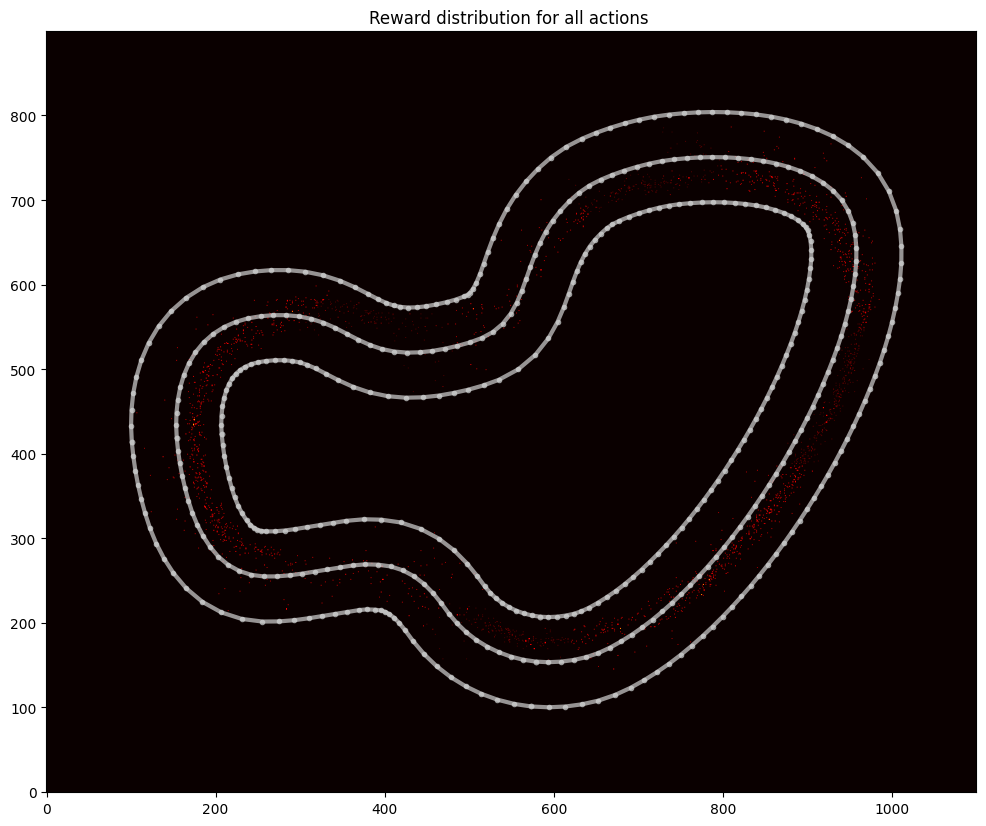

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 16: steering: -30.0, throttle: 2.5


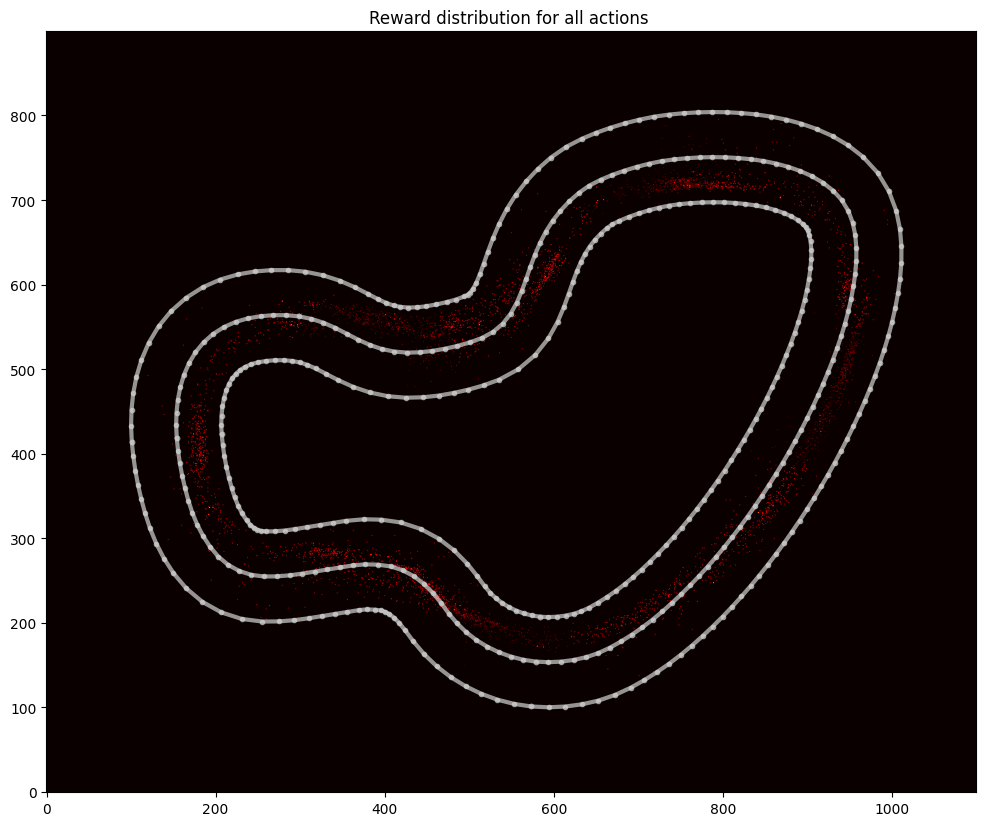

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 17: steering: 30.0, throttle: 2.5


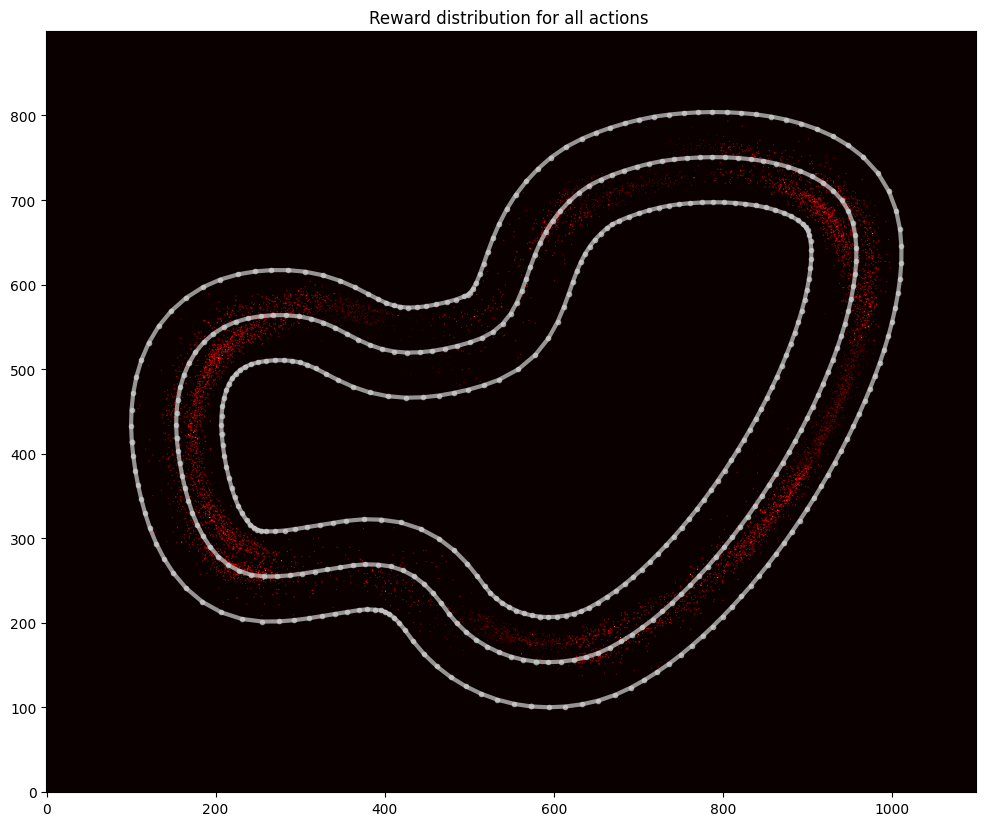

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 18: steering: 0.0, throttle: 4.0


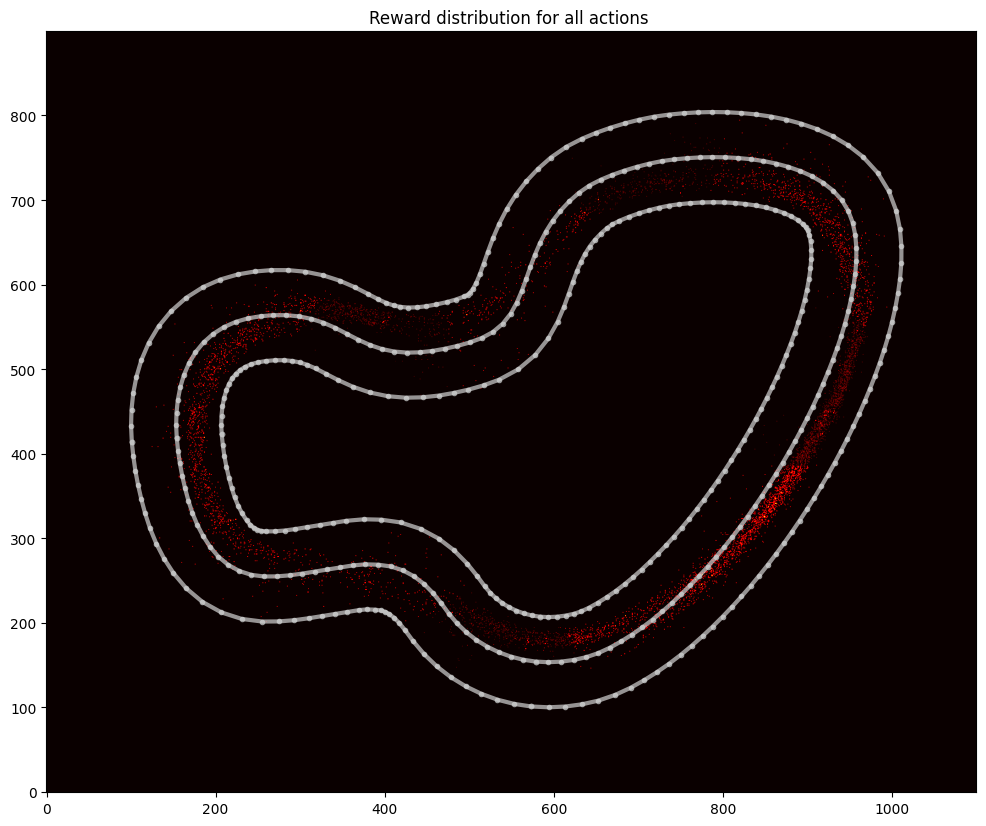

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 19: steering: -7.5, throttle: 4.0


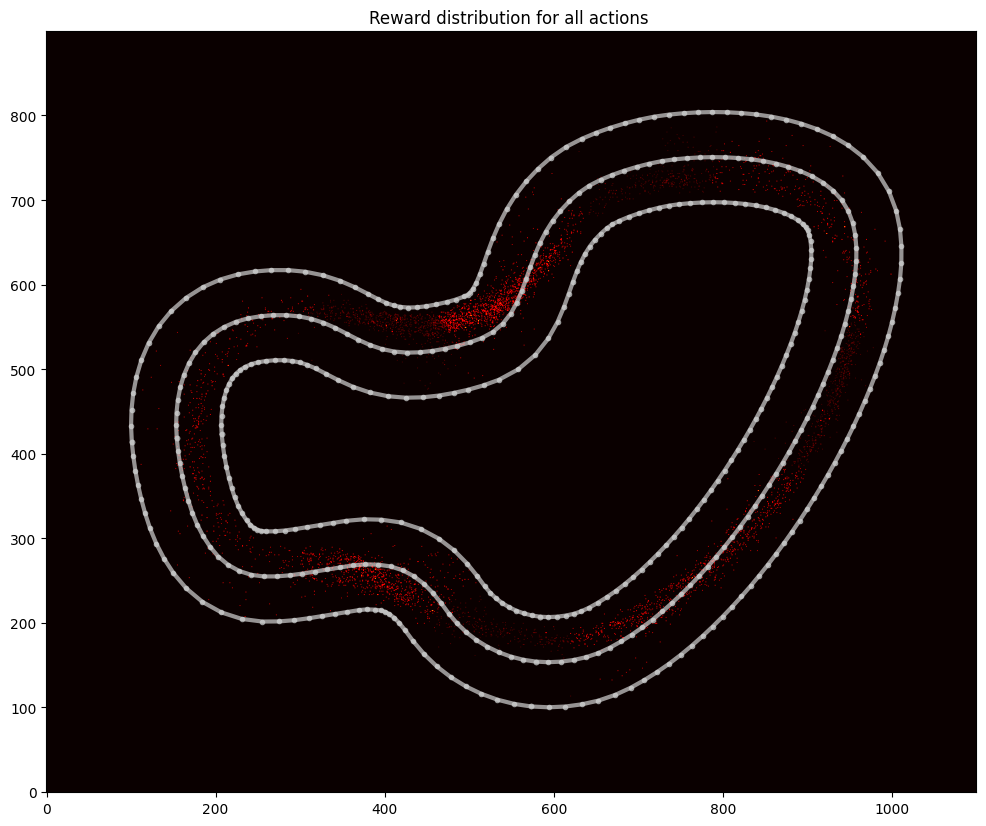

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 20: steering: 7.5, throttle: 4.0


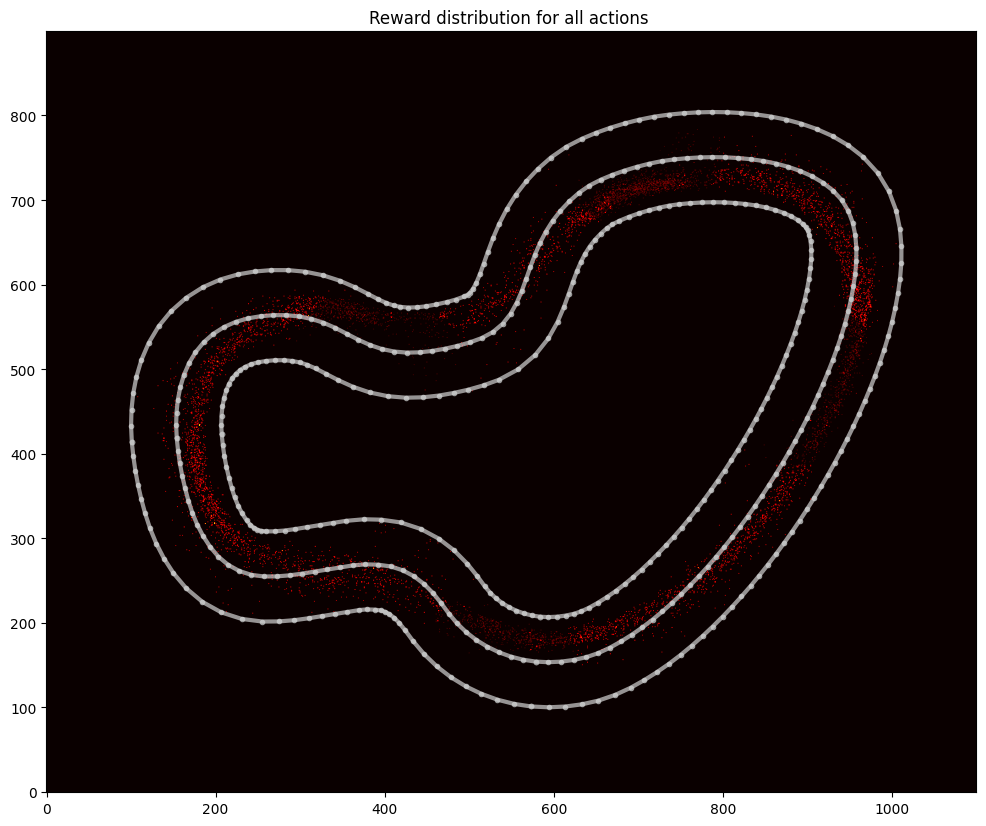

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 21: steering: -15.0, throttle: 4.0


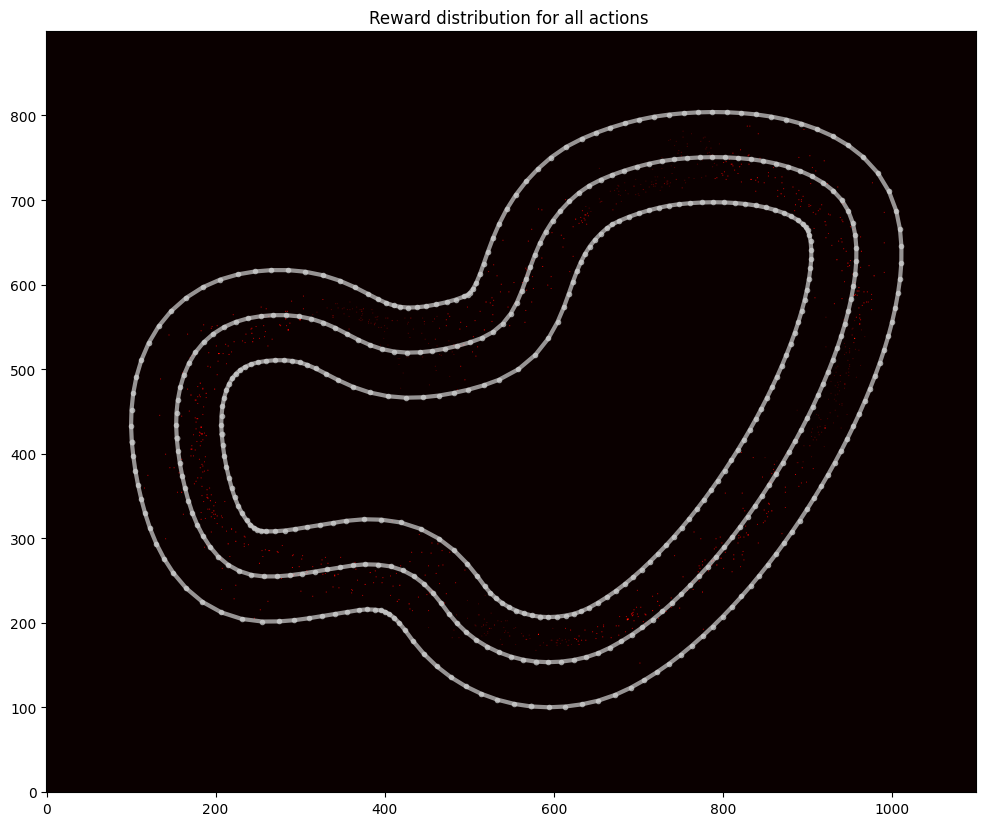

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 22: steering: 15.0, throttle: 4.0


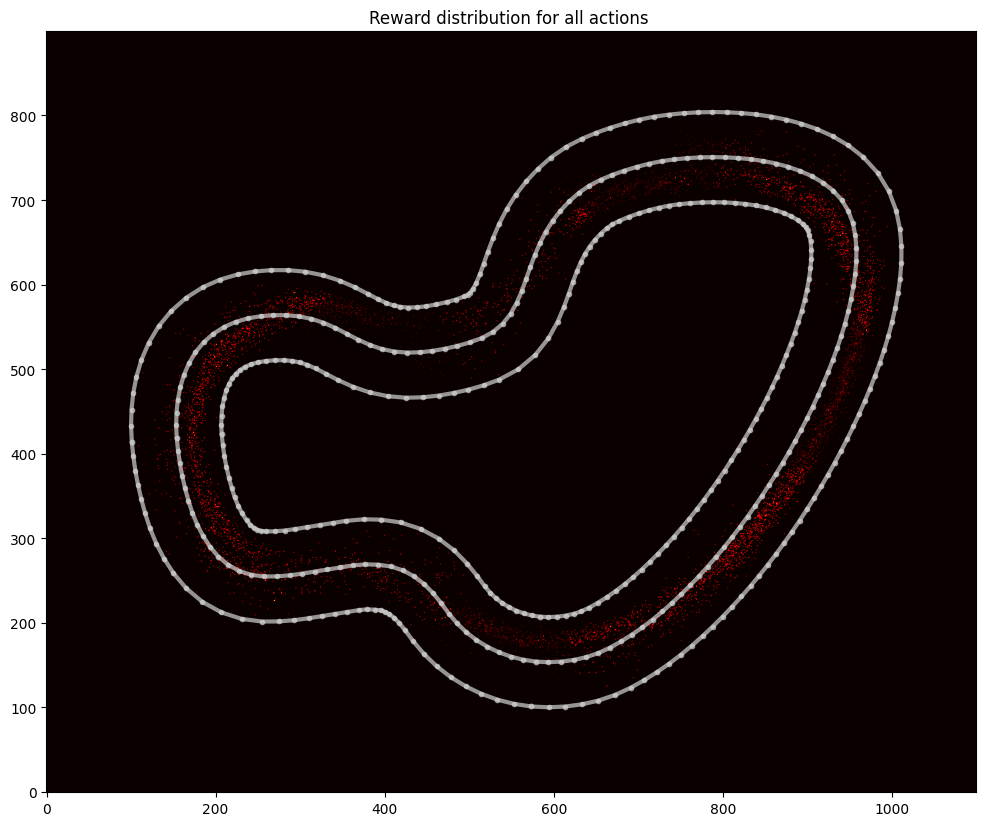

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 23: steering: -22.5, throttle: 4.0


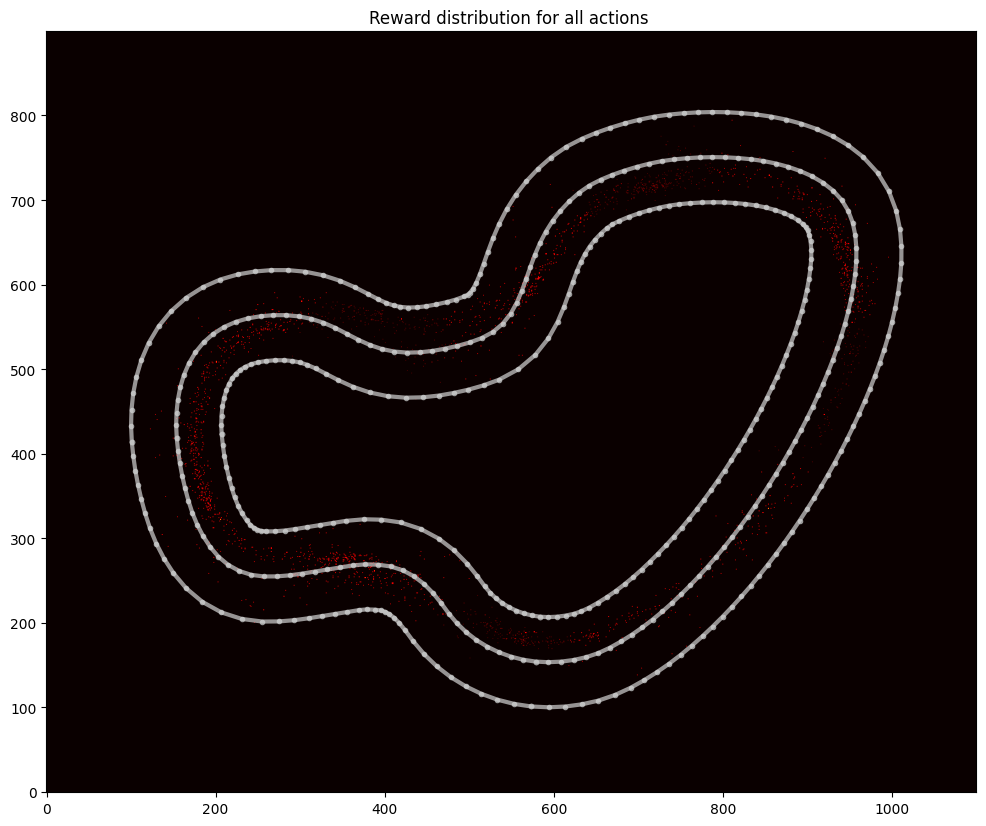

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 24: steering: 22.5, throttle: 4.0


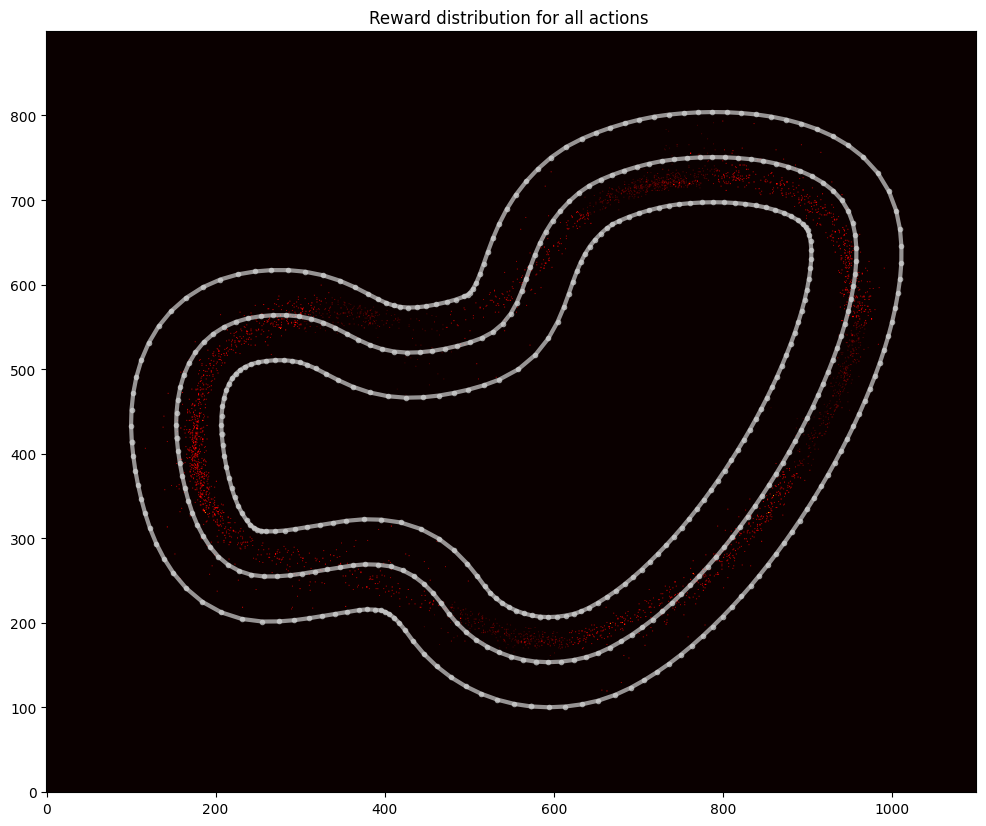

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 25: steering: -30.0, throttle: 4.0


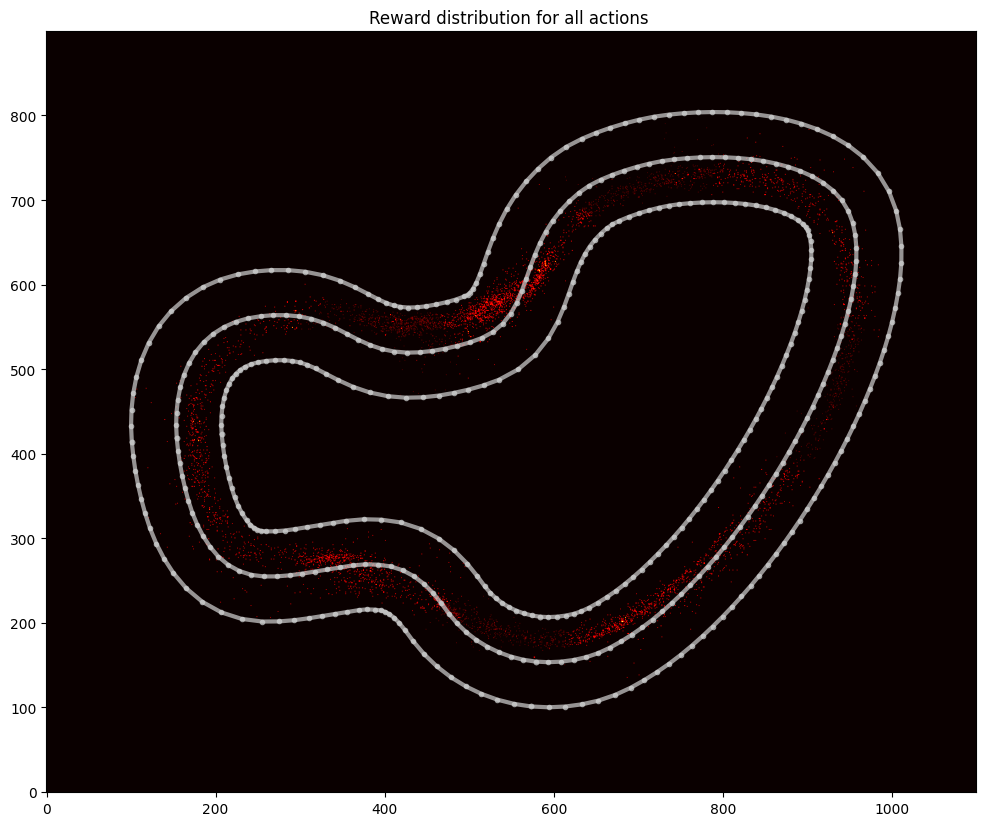

<Figure size 640x480 with 0 Axes>



 Heatmap for action with index 26: steering: 30.0, throttle: 4.0


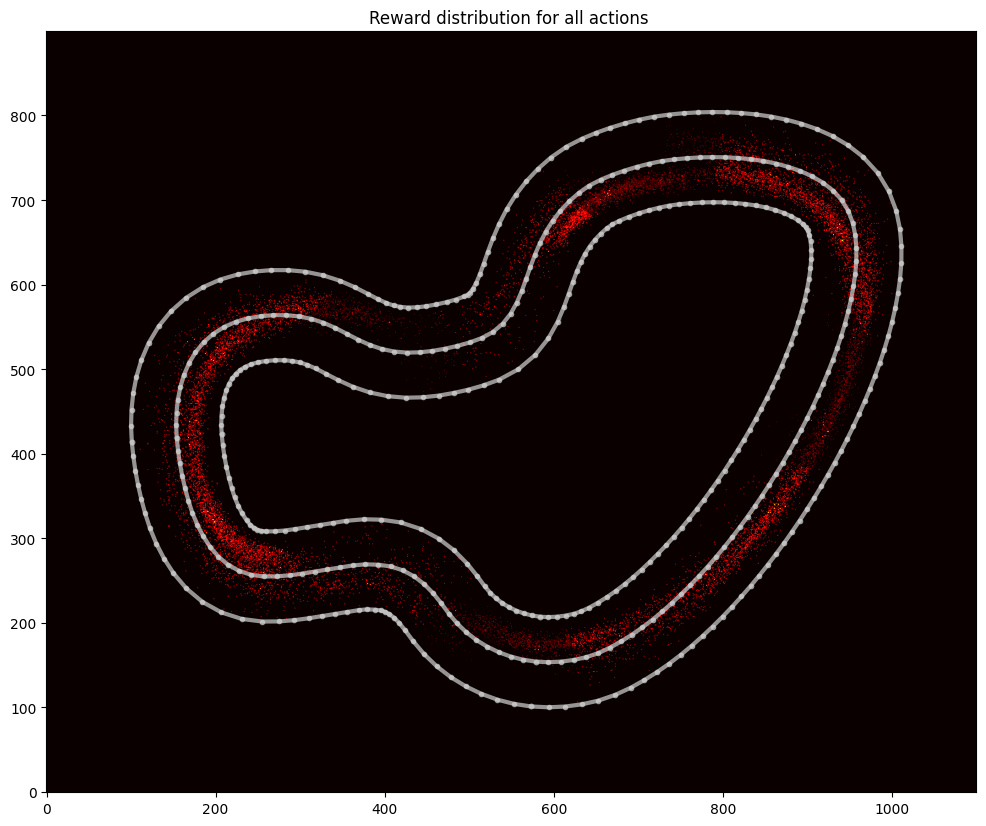

<Figure size 640x480 with 0 Axes>

In [62]:
aslNum = len(asl)
setActions = range(aslNum)     # show graphs for all Actions
#setActions = (0,1,6,8,9)       # show graphs only for index set Actions
fig = plt.figure(aslNum)
for i in setActions: 
    a = asl[i]
    print("\n\n Heatmap for action with index {}: steering: {}, throttle: {}".format(a.index, a.steer,a.throttle))
    tr_plot = pu.plot_track(df[df['action'] == a.index], track, value_field="reward") 
    plt.show()